# A Spatial Analysis of NCAA Shooting Behaviors

## Abstract

In this report, I show that the BigQuery Storage API and the Spark-BigQuery connector can be used to load and analyze the high volume of shooting data available for NCAA Men's Basketball. By running SQL queries on this dataset, I both quantify and visualize general shooting behaviors in the NCAA, as well as shooting trends that have developed over a five-season period. Additionally, I use non-negative matrix factorization to delve deeper into the underlying structure of NCAA player shooting distributions. By analyzing the resulting spatial basis functions, I can draw conclusions about different shot type preferences in the NCAA. By using non-negative matrix factorization as a clustering technique, I categorize players with similar shooting behaviors. Lastly, applying non-negative matrix factorization over several seasons separately, I visualize how shooting preferences have changed over time. The results of this analysis are useful in understanding how NCAA Men’s Basketball has developed over the past decade. These results could also help teams make optimal lineup selections, ensuring that every player is occupying the area on the court where they prefer to shoot.

## 1 &emsp; Introduction

Basketball shooting distributions have traditionally been analyzed in one of two ways. The first approach is to "bin" the data into one of a small number of categories (*i.e.* "rim," "paint," "mid-range" and "threes") and compare the distributions. However, this suffers from the incorrect assumption that shooting is symmetric. Players realistically tend to favor one side of the court to another, resulting in shooting distributions that are either right-dominant or left-dominant. The second approach to analyzing shooting distributions is to analyze shot charts. Shot charts do serve as a helpful tool to visualize a player's made and missed shots on the court, and can also be helpful in pointing out some significant differences (*i.e.* a player who shoots a lot of three-pointers compared with a player who prefers not to venture too far outside of the paint). Shots charts are not able to reveal much, however, when it comes to determining how much two shot distributions differ. Shot charts are intuitively difficult to compare because charts that look quite similar may have very different underlying distributions.

Because shots can be represented in matrix form, one suitable improvement to analyzing shot distributions is matrix factorization. The goal of matrix factorization is to express the original data matrix $V$ as the product of two factor matrices, $W$ and $H$. These factors include latent patterns of the original data. One specific matrix factorization method, called non-negative matrix factorization (NMF), is especially well-suited for the application of shooting data because the matrices are all constrained to be non-negative. This makes intuitive sense because we would never expect the number of shot attempts in any area of the court to fall below zero. By examining and plotting the resulting basis matrix $H$, it is possible to create a visual representation of offensive tendencies in the NCAA. Additionally, I take advantage of the fact that NMF can be used as a clustering technique. By comparing the values in the resulting weight matrix $W$ it is also possible to categorize NCAA players based on their shooting behaviors.

There have been several studies over the years applying machine learning and/or dimensionality reduction techniques to basketball player tracking data. In Piette *et al.* (2011), the authors apply k-means clustering to categorize players by a standardized version of their shot distributions [1]. In Bruce (2016), the author used principal component analysis (PCA) to identify four components accounting for 68% of the variation in NBA player tracking data from the 2013-14 regular season. Using these four principal components, the author also constructed a similarity index for player and team statistical profiles [2]. Most closely related to my analysis is Miller *et al.* (2014), where the authors developed a machine learning approach to represent and analyze the underlying spatial structure governing shot selection among NBA players. They found a non-parametric estimate of each player’s smooth intensity surface, which they modeled as a Log-Gaussian Cox Process (LGCP). In doing so, they created a low-dimensional representation of NBA player shooting types. Then by applying NMF they show that a low-rank spatial decomposition can summarize shooting types in the NBA [3]. This methodology was used again a year later by some of the same authors in Franks *et al.* (2015). This time, the analysis was part of a larger study attempting to advance the state of spatial defensive analytics in the NBA [4]. In my study, I apply a lot of these same methods, this time to NCAA Men’s Basketball shot data. Unlike these previous studies, however, I smooth each player’s intensity surface using multidimensional Gaussian filtering. This is a technique commonly used in image processing to reduce unnecessary noise.

This paper is organized into eight sections. The next section discusses the theory and intuition behind the methods used in this analysis. Section 3 contains a description of the NCAA Men's Basketball dataset, its origin and some of its primary attributes. In Section 4, I detail some of the initial steps taken to create a Cloud Dataproc cluster and access the Jupyter Notebook interface. This section also covers how to initially load the data in the Jupyter Notebook, as well as some functions that were written in order to create shot charts. Section 5 contains some exploratory analysis, in which I query the dataset to gain some initial insight into NCAA shooting trends and behaviors. In Section 6, I take this a step further by applying non-negative matrix factorization (NMF) to uncover the underlying structure of NCAA player shooting distributions. Section 7 contains the results, including an interpretation of the resulting spatial basis functions, as well as extensions of this analysis to categorize NCAA players by shot preferences and to analyze changes in shooting preferences over a five-season period. The final section contains a discussion of the conclusions and possible directions for future work.

## 2 &emsp; Background

The following section provides a brief overiew of the theory and intuitions behind the following techniques: (1) multidimensional Gaussian filtering; and (2) non-negative matrix factorization (NMF). The implementation of these techniques are discussed in further detail in Section 6.

### 2.1 &emsp; Multidimensional Gaussian Filtering

Gaussian filtering is a method used to blur images, thereby reducing both noise and detail. The goal of applying a Gaussian filter is to attain a more accurate intensity surface. In one dimension, the Gaussian function is:

$G(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{x^2}{2 \sigma^2}}, \label{eq1}\tag{1}$

where $\sigma$ is the standard deviation of the distribution. Additionally, the distribution is assumed to have a zero mean. Graphically, the Gaussian distribution has a characteristic "bell curve" shape, where $\sigma$ controls the width of the "bell." 

![Gaussian Distribution](https://introcs.cs.princeton.edu/python/appendix_gaussian/images/stddev.png)

When applying a Gaussian filter to an image it is necessary to use a two-dimensional Gaussian function:

$G(x,y) = \frac{1}{2 \pi \sigma^2} e^{-\frac{x^2 + y^2}{2 \sigma^2}}, \label{eq2}\tag{2}$

which is simply the product of two one-dimensional Gaussian functions $G(x)$ and $G(y)$. The Gaussian filter works by using this two-dimensional distribution as a point-spread function. Since an image is stored as a collection of discrete pixels, the first step is to find a discrete approximation to the Gaussian function. Theoretically, this would require an infinitely large kernel because the Gaussian distribution is never equal to zero. Thankfully, however, the distribution approaches zero after three standard deviations from the mean. The kernel size can therefore be limited to contain only values within this range.

Once a suitable kernel has been calculated, Gaussian filtering can be applied using convolutional methods. A two-dimensional convolution can be performed by first convolving with a one-dimensional Gaussian in the *x*-direction, and then convolving with another one-dimensional Gaussian in the *y*-direction. The effect of Gaussian filtering is to blur an image, where the degree of smoothing is determined by $\sigma$. The Gaussian outputs a weighted average of each pixel's neighborhood, with higher weight being allocated to the central pixels. Compared to a uniform mean filter, Gaussian filtering is smoother and better at preserving edges. Like most convolutional-based smoothing filters, Gaussian is a true low-pass filter. This means that all high spatial frequency components are effectively removed.  

### 2.2 &emsp; Non-Negative Matrix Factorization

Non-negative matrix factorization (NMF) is a popular unsupervised learning technique for dimensionality reduction. Suppose you have a data matrix $V \in \mathbb{R}^{m \: \times \: n}$, where each and every element $v_{ij} \geq 0$. NMF seeks to find two non-negative matrices $W$ and $H$ such that:

$V \approx WH, \label{eq3}\tag{3}$ 

where $W \in \mathbb{R}^{m \: \times \: k}$ and $H \in \mathbb{R}^{k \: \times \: n}$. The quantity $k$ is user-specified, but should be smaller than both $m$ and $n$ so that $W$ and $H$ can be smaller than the original data matrix $V$. The matrix $H$ is typically referred to as the basis matrix, while the matrix $W$ is called the weight matrix. The underlying idea here is that the given data matrix $V$ can be expressed as the summation of $k$ basis vectors (the columns of $W$) multiplied by their corresponding coefficients (the columns of $H$):

$v_i = \begin{bmatrix} w_{i1} & w_{i2} & \cdots & w_{ik} \end{bmatrix} \times \begin{bmatrix} h_1 \\ h_2 \\ \vdots \\ h_k \end{bmatrix} = \sum_{j=1}^k w_{ij} \times h_i.  \label{eq4}\tag{4}$

Finding the appropriate factorization $V \approx WH$ involves minimizing a specified cost function. This cost function is responsible for quantifying the quality of the approximation, and can be constructed by using some measure of distance between two non-negative matrices $X$ and $Y$. One of the measures considered in this analysis is the Frobenius norm: 

$\parallel X - Y \parallel^2 = \sum_{ij}(X_{ij} - Y_{ij})^2.  \label{eq5}\tag{5}$

The other measure is the Kullback-Leibler (KL) divergence:

$D(X \parallel Y) = \sum_{ij}(X_{ij} log \frac{X_{ij}}{Y_{ij}} - X_{ij} + Y_{ij}). \label{eq6}\tag{6}$

In the context of NMF, the goal is to minimize either of the above cost functions (where $X = V$ and $Y = WH$) with respect to $W$ and $H$ and subject to the constraints $W, H \geq 0$. The two most popular methods for minimizing these cost functions are gradient descent and multiplicative update rules. Gradient descent, while easier to implement, is often slow to converge and is known to be highly sensitive to the choice of step size. The multiplicative update rules approach, on the other hand, provides a good compromise between simplicity and speed of convergence. In this method, popularized in 2001 by Lee and Seung, $W$ and $H$ are updated iteratively according to a set of rules [5]. For the Frobenius norm, the basic update rules are:

$H_{a\mu} \leftarrow H_{a\mu} \frac{(W^TV)_{a\mu}}{(W^TWH)_{a\mu}} \qquad W_{ia} \leftarrow W_{ia} \frac{(VH^T)_{ia}}{(WHH^T)_{ia}}. \label{eq7}\tag{7}$

For the Kullback-Leibler (KL) divergence, the basic update rules are:

$H_{a\mu} \leftarrow H_{a\mu} \frac{\sum_i W_{ia} V_{i\mu} \: / \: (WH)_{i\mu}}{\sum_k W_{ka}} \qquad W_{ia} \leftarrow W_{ia} \frac{\sum_{\mu} H_{a\mu} V_{i\mu} \: / \: (WH)_{i\mu}}{\sum_v H_{av}} \label{eq8}\tag{8}$

Because the cost functions $\parallel V - WH \parallel$ and $D(V \parallel WH)$ are only convex in $W$ and $H$ individually, there is no guarantee that a global minimum will be found. By applying the multiplicative update rules, however, convergence to at least a locally optimal solution is guaranteed. Additionally, it can be proven that the objective functions are non-increasing at each iteration.

## 3 &emsp; Data

The data for this report comes from the *mbb_pbp_sr* table in Google BigQuery's [NCAA Basketball dataset](https://console.cloud.google.com/marketplace/details/ncaa-bb-public/ncaa-basketball) [6]. The BigQuery NCAA Basketball dataset as a whole was compiled by Google Cloud, the NCAA and Sportradar (a global sports data and contant provider) and contains over 42,000,000 unique plays from every men's and women's college basketball game since the 2009-10 season. The *mbb_pbp_sr* table specifically contains NCAA Men's Basketball play-by-play data. When loading the table into Jupyter Notebook, I filter it to include field goals only. Additionally, I exclude any observations in which the shot location (`event_coord_x` and `event_coord_y`) is missing. As shown in Section 4, the resulting dataset contains over one million individual shots and ranges from the 2013-14 season to the 2017-18 season. There are 71 columns containing descriptive information about each shot, such as shot type, whether the shot was worth two points or three, and whether the shot was missed or made. Other columns contain information about the player who attempted the shot, his school, and the game in which the shot was taken.

As discussed throughout Section 4 and Section 5, there are some minor issues with the dataset. The first is that shot type does not seem to be recorded until the 2014-15 season. This does not affect the non-negative matrix factorization done in Section 6, as that method relies on the $(x,y)$-coordinates alone. It does, however, affect some of the initial queries that I run in Section 5 to explore general shooting trends in the NCAA. Second, the number of games for which $(x,y)$-coordinates were recorded differs per season. The 2013-14 season has a disproportionately low number of games, while the 2015-16 season has a disproportionately high number of games. These differences are reflected in the total number of shots per season. That being said, the number of shots per season remains quite high (averaging just over 250,000) so no further action is required.

## 4 &emsp; Initial Setup

In this section, I discuss the initial steps that I take to: (1) create a Cloud Dataproc cluster and open a Jupyter Notebook using the gcloud command-line tool; (2) load the NCAA Basketball dataset using the Spark-BigQuery connector; and (3) design shot charts as a way to visualize the data. Please note that in order to replicate this analysis on a Mac operating system, one must be aware of the following command-line syntax differences: (1) any carets (`^`) should be replaced by a backwards slash (`\`); and (2) double quotes (`"`) should be replaced by single quotes (`'`). 

### 4.1 &emsp; The BigQuery Storage API and Spark-BigQuery Connector

For this analysis, I make use of the [BigQuery Storage API](https://cloud.google.com/bigquery/docs/reference/storage) to access the NCAA Basketball dataset [7]. The BigQuery Storage API is the best option available for accessing BigQuery-managed tables, namely because of its use of an RPC-based protocol. When using the BigQuery Storage API, data is streamed in parallel directly from BigQuery via gRPC (a high performance, open source, general-purpose RPC framework) without using Google Cloud Storage as an intermediary. The BigQuery Storage API also has a number of key features, the most notable of which is the ability to filter data before reading it in. By making use of a columnar datastore, the BigQuery Storage API can process data efficiently without having to read every column. 

The [Spark-BigQuery connector](https://github.com/GoogleCloudDataproc/spark-bigquery-connector) takes advantage of the BigQuery Storage API when reading in BigQuery-managed tables [8]. This connector uses the Spark SQL Data Source API to communicate with BigQuery, allowing the user to read Google BigQuery tables into Spark DataFrames. In order to use the Spark-BigQuery connector, the BigQuery Storage API must first be enabled. Next, the connector must be downloaded in the form of a jar file. The latest version of the connector is publicly available in [gs://spark-lib/bigquery/spark-bigquery-latest.jar](gs://spark-lib/bigquery/spark-bigquery-latest.jar). The connector can either be installed when initializing a Dataproc cluster or can be added as an external jar in Jupyter Notebook.

### 4.2 &emsp; Creating a Cloud Dataproc Cluster and Accessing the Jupyter Notebook Web Interface

The first step is to make sure that the BigQuery API and the BigQuery Storage API are both enabled. Both of these APIs should be automatically enabled when creating a new project, so this step is really just to double check.

```
gcloud services enable bigquery.googleapis.com ^
  bigquerystorage.googleapis.com
```

Once it has been ensured that the necessary APIs are enabled, I create a Google Cloud Storage bucket to be used by my Dataproc cluster.

```
gsutil mb gs://<my-bucket-name>/
```

Next, I use a text editor to write a shell script called *my-actions.sh.* This script installs the appropriate versions of the packages needed for my analysis, such as *google-cloud-bigquery, seaborn, matplotlib,* and *scipy.* Once complete, I navigate to the location where *my-actions.sh* is saved and copy the shell script into my bucket.

```
cd <filepath-to-my-actions.sh>

gsutil cp my-actions.sh gs://<my-bucket-name>/
```

Once *my-actions.sh* has been uploaded to my bucket, I am ready to create my Dataproc cluster. By specifying the optional components `ANACONDA` and `JUPYTER`, I ensure that all of the necessary libraries for those two platforms will be installed. The line `enable-component-gateway` allows me direct web access to Jupyter Notebook without having to create an SSH tunnel. By specifying image version `1.4-debian10` I am able to use a Python3 kernel to run PySpark code. The `--metadata` and `--initialization-actions` lines ensure that the appropriate versions of my specified Python libraries are installed. Note that I do not install the Spark-BigQuery connector when initializing my cluster. I have opted to add the connector as an external jar in Jupyter Notebook instead.

```
cd <filepath-to-home-directory>

gcloud beta dataproc clusters create <my-cluster-name> ^
	--project <project-id> ^
	--bucket <my-bucket-name> ^
	--zone europe-west2-a ^
	--master-machine-type n1-standard-4 ^
	--master-boot-disk-size 500 ^
	--num-workers 2 ^
	--worker-machine-type n1-standard-4 ^
	--worker-boot-disk-size 500 ^
	--image-version 1.4-debian10 ^
	--optional-components=ANACONDA,JUPYTER ^
	--enable-component-gateway ^
	--initialization-actions gs://goog-dataproc-initialization-actions-europe-west2/python/pip-install.sh,gs://<my-bucket-name>/my-actions.sh ^
	--metadata "PIP_PACKAGES=google-cloud-bigquery seaborn matplotlib numpy scipy scikit-image"
```

Now that my cluster has been created, I am ready to open Jupyter Notebook.

```
gcloud beta dataproc clusters describe <my-cluster-name> --region=europe-west2
```

Near the top of the output, there is a link next to *Jupyter* that can be copy/pasted directly into a web browser. Once I am in Jupyter Notebook, I open a new notebook and make sure that it has a Python3 kernel.

### 4.3 &emsp; Loading NCAAM Shot Logs Using the Spark-BigQuery Connector

Now that I have my notebook open, the first thing that I do is install all of the necessary packages for this analysis.

In [1]:
# Import libraries
from IPython.display import display
from math import pi
from matplotlib.patches import Circle, Rectangle, Arc
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT
from scipy import ndimage
from scipy.stats import binned_statistic_2d
from sklearn.preprocessing import normalize, Normalizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pyspark.sql.functions as f
import pyspark.sql.types as t
import seaborn as sns
import sklearn.decomposition as skld
%matplotlib inline

Next, I create a Spark session and include the spark-bigquery-connector jar. To ensure that I am using the correct jar file, I first check my Scala version. Since I am using Scala version 2.11, I use the latest version of the connector in `gs://spark-lib/bigquery/spark-bigquery-latest.jar.` If I had been using Scala 2.12, I would have used the compiled version in `gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar.`

In [2]:
# Check the scala version
!scala -version

cat: /release: No such file or directory
Scala code runner version 2.11.12 -- Copyright 2002-2017, LAMP/EPFL


In [2]:
# Build the spark session
spark = SparkSession.builder \
  .appName('NCAA Shooting Behaviors')\
  .config('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest.jar') \
  .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

Now that my Spark session has been created, I am ready to load the data from the `mbb_pbp_sr` table from the NCAA Basketball dataset into a Spark DataFrame. Once my DataFrame has been created, I print out the schema to get a better sense of the variables in my dataset. The dataset has 71 columns total, with plenty of descriptive information for each play-by-play event.

In [3]:
# Create the BigQuery table and print the schema to list all of the columns and variable types
df = spark.read \
  .format("bigquery") \
  .option("table", "bigquery-public-data.ncaa_basketball.mbb_pbp_sr") \
  .load()
df.printSchema()
df.createOrReplaceTempView('df')

root
 |-- game_id: string (nullable = true)
 |-- load_timestamp: timestamp (nullable = true)
 |-- season: long (nullable = true)
 |-- status: string (nullable = true)
 |-- scheduled_date: timestamp (nullable = true)
 |-- venue_id: string (nullable = true)
 |-- venue_name: string (nullable = true)
 |-- venue_city: string (nullable = true)
 |-- venue_state: string (nullable = true)
 |-- venue_address: string (nullable = true)
 |-- venue_zip: string (nullable = true)
 |-- venue_country: string (nullable = true)
 |-- venue_capacity: long (nullable = true)
 |-- attendance: long (nullable = true)
 |-- neutral_site: boolean (nullable = true)
 |-- conference_game: boolean (nullable = true)
 |-- tournament: string (nullable = true)
 |-- tournament_type: string (nullable = true)
 |-- round: string (nullable = true)
 |-- game_no: string (nullable = true)
 |-- away_market: string (nullable = true)
 |-- away_name: string (nullable = true)
 |-- away_id: string (nullable = true)
 |-- away_alias: stri

The Spark DataFrame that I just created contains information for all kinds of play-by-play events. However, for this analysis, I am only interested in looking at shooting data. As a result, I write a SQL query to filter the original dataframe to `type = "fieldgoal"` and add the additional specifications `event_coord_x IS NOT NULL` and `event_coord_y IS NOT NULL` just to make sure that the resulting DataFrame does not contain any shots with missing locations.

In [4]:
# Write SQL query
query_string = """
    SELECT *
    FROM df
    WHERE type = "fieldgoal"
        AND event_coord_x IS NOT NULL
        AND event_coord_y IS NOT NULL
    ORDER BY season
"""

# Run query and save to Spark dataframe
df_full = spark.sql(query_string)

# Check the dimensions of the dataset (rows, columns)
print((df_full.count(), len(df_full.columns)))

(1271971, 71)


The resulting DataFrame contains 1,271,971 unique shots. To get a better sense of what the data looks like, I print out the first and last few rows below.

In [6]:
# Print first few rows
df_full.orderBy("season", "event_id").limit(5)

game_id,load_timestamp,season,status,scheduled_date,venue_id,venue_name,venue_city,venue_state,venue_address,venue_zip,venue_country,venue_capacity,attendance,neutral_site,conference_game,tournament,tournament_type,round,game_no,away_market,away_name,away_id,away_alias,away_conf_name,away_conf_alias,away_division_name,away_division_alias,away_league_name,home_market,home_name,home_id,home_alias,home_conf_name,home_conf_alias,home_division_name,home_division_alias,home_league_name,period,game_clock,elapsed_time_sec,possession_arrow,team_name,team_market,team_id,team_alias,team_conf_name,team_conf_alias,team_division_name,team_division_alias,team_league_name,team_basket,possession_team_id,player_id,player_full_name,jersey_num,event_id,timestamp,event_description,event_coord_x,event_coord_y,event_type,type,shot_made,shot_type,shot_subtype,three_point_shot,points_scored,turnover_type,rebound_type,timeout_duration
dca228a0-371f-412...,2018-02-01 15:38:...,2013,closed,2013-11-26 19:00:00,c69e13a7-4637-4b0...,Lahaina Civic Center,Maui,HI,1840 Honoapiilani...,96761,USA,2400,2400,false,false,null,null,null,null,Arkansas,Razorbacks,c70c23c4-ab09-479...,ARK,Southeastern,SEC,NCAA Division I,D1,NCAA MEN,Minnesota,Golden Gophers,fa416692-7e09-4f0...,MINN,Big Ten,BIG10,NCAA Division I,D1,NCAA MEN,2,1:18,2322,null,Golden Gophers,Minnesota,fa416692-7e09-4f0...,MINN,Big Ten,BIG10,NCAA Division I,D1,NCAA MEN,right,null,39a0633e-2e69-422...,Austin Hollins,20,0000569c-ac88-415...,2013-11-26 21:06:00,Austin Hollins mi...,890.0,94.0,threepointmiss,fieldgoal,false,null,null,true,null,null,null,null
9dd937a4-2b43-47d...,2018-02-01 07:37:...,2013,closed,2014-03-21 01:38:00,9bb9599c-17dd-425...,BMO Harris Bradle...,Milwaukee,WI,1001 N Fourth St,53203,USA,18717,17331,false,false,NCAA,Midwest Regional,Second Round,Game 7,Arizona State,Sun Devils,ad4bc983-8d2e-4e6...,ASU,Pacific 12,PAC12,NCAA Division I,D1,NCAA MEN,Texas,Longhorns,6ed15092-2670-450...,TEX,Big 12,BIG12,NCAA Division I,D1,NCAA MEN,1,11:29,511,null,Sun Devils,Arizona State,ad4bc983-8d2e-4e6...,ASU,Pacific 12,PAC12,NCAA Division I,D1,NCAA MEN,right,null,a3ec21a0-940c-46b...,Jordan Bachynski,13,0000621b-4d45-4e5...,2014-03-21 01:59:02,Prince Ibeh block...,1023.0,341.0,twopointmiss,fieldgoal,false,null,null,false,null,null,null,null
7af0d495-633a-429...,2018-02-01 14:49:...,2013,closed,2013-11-22 01:00:00,9bb9599c-17dd-425...,BMO Harris Bradle...,Milwaukee,WI,1001 N Fourth St,53203,USA,18717,13522,false,false,null,null,null,null,New Hampshire,Wildcats,93cb009e-5bbf-408...,UNH,America East,AE,NCAA Division I,D1,NCAA MEN,Marquette,Golden Eagles,06f7c904-0ac7-412...,MARQ,Big East,BIGEAST,NCAA Division I,D1,NCAA MEN,2,7:28,1952,null,Wildcats,New Hampshire,93cb009e-5bbf-408...,UNH,America East,AE,NCAA Division I,D1,NCAA MEN,left,06f7c904-0ac7-412...,28efb310-a4d4-408...,Daniel Dion,30,00008153-dae6-4e3...,2013-11-22 02:43:04,Daniel Dion makes...,302.0,121.0,threepointmade,fieldgoal,true,null,null,true,3.0,null,null,null
e49d6a35-0f4a-4ef...,2018-02-01 14:44:...,2013,closed,2014-01-26 00:00:00,dd352ce9-3282-4d7...,Louis Brown Athle...,Piscataway,NJ,83 Rockafeller Road,8854,USA,8000,8006,false,true,null,null,null,null,Connecticut,Huskies,efba5350-79bc-47a...,CONN,American Athletic,AAC,NCAA Division I,D1,NCAA MEN,Rutgers,Scarlet Knights,b03bb029-4499-4a2...,RUTG,Big Ten,BIG10,NCAA Division I,D1,NCAA MEN,1,17:07,173,null,Huskies,Connecticut,efba5350-79bc-47a...,CONN,American Athletic,AAC,NCAA Division I,D1,NCAA MEN,left,b03bb029-4499-4a2...,54b9624e-1f14-4e8...,Amida Brimah,35,000097ac-3369-472...,2014-01-26 00:08:19,Amida Brimah make...,70.0,300.0,twopointmade,fieldgoal,true,null,null,false,2.0,null,null,null
e600a422-36e6-462...,2018-02-01 15:45:...,2013,closed,2013-11-22 01:00:00,365700aa-9e46-4b9...,TD Arena,Charleston,SC,66 George Street,29424,USA,5100,2311,false,false,null,null,null,null,Temple,Owls,8598d1b6-106b-408...,TEM,American Athletic,AAC,NCAA Division I,D1,NCAA MEN,Clemson,Tigers,dcf5c2e7-c

In [7]:
# Print the last few rows
df_full.orderBy("season", "event_id", ascending=False).limit(5)

game_id,load_timestamp,season,status,scheduled_date,venue_id,venue_name,venue_city,venue_state,venue_address,venue_zip,venue_country,venue_capacity,attendance,neutral_site,conference_game,tournament,tournament_type,round,game_no,away_market,away_name,away_id,away_alias,away_conf_name,away_conf_alias,away_division_name,away_division_alias,away_league_name,home_market,home_name,home_id,home_alias,home_conf_name,home_conf_alias,home_division_name,home_division_alias,home_league_name,period,game_clock,elapsed_time_sec,possession_arrow,team_name,team_market,team_id,team_alias,team_conf_name,team_conf_alias,team_division_name,team_division_alias,team_league_name,team_basket,possession_team_id,player_id,player_full_name,jersey_num,event_id,timestamp,event_description,event_coord_x,event_coord_y,event_type,type,shot_made,shot_type,shot_subtype,three_point_shot,points_scored,turnover_type,rebound_type,timeout_duration
dc37d4f3-0457-48a...,2018-02-15 17:11:...,2017,closed,2017-12-23 19:30:00,0b181487-42ee-432...,Auburn Arena,Auburn,AL,250 Beard-Eaves C...,36849,USA,null,8039,false,false,null,null,null,null,Connecticut,Huskies,efba5350-79bc-47a...,CONN,American Athletic,AAC,NCAA Division I,D1,NCAA MEN,Auburn,Tigers,0c0608b3-f349-4f5...,AUB,Southeastern,SEC,NCAA Division I,D1,NCAA MEN,2,7:01,1979,0c0608b3-f349-4f5...,Huskies,Connecticut,efba5350-79bc-47a...,CONN,American Athletic,AAC,NCAA Division I,D1,NCAA MEN,right,0c0608b3-f349-4f5...,bd78ce6f-5b8f-495...,Terry Larrier,22,ffff33ca-0165-495...,2017-12-23 21:11:04,Terry Larrier mak...,873.0,215.0,twopointmade,fieldgoal,true,jump shot,null,false,2.0,null,null,null
fbbd167b-94b8-462...,2018-02-15 17:21:...,2017,closed,2018-01-10 02:00:00,0b181487-42ee-432...,Auburn Arena,Auburn,AL,250 Beard-Eaves C...,36849,USA,null,9121,false,true,null,null,null,null,Ole Miss,Rebels,d7d668ec-edaa-4d6...,MISS,Southeastern,SEC,NCAA Division I,D1,NCAA MEN,Auburn,Tigers,0c0608b3-f349-4f5...,AUB,Southeastern,SEC,NCAA Division I,D1,NCAA MEN,1,1:04,1136,d7d668ec-edaa-4d6...,Rebels,Ole Miss,d7d668ec-edaa-4d6...,MISS,Southeastern,SEC,NCAA Division I,D1,NCAA MEN,left,0c0608b3-f349-4f5...,ca214b56-6a5a-491...,Terence Davis,3,ffff27a2-a3bd-4d3...,2018-01-10 02:51:20,Terence Davis mak...,79.0,287.0,twopointmade,fieldgoal,true,layup,null,false,2.0,null,null,null
cc28f7de-1a93-476...,2018-02-15 16:59:...,2017,closed,2017-12-03 03:00:00,1c5db5ab-5da3-470...,Thomas & Mack Center,Paradise,NV,4505 S Maryland P...,89119,USA,null,14579,false,false,null,null,null,null,Arizona,Wildcats,9b166a3f-e64b-482...,ARIZ,Pacific 12,PAC12,NCAA Division I,D1,NCAA MEN,UNLV,Rebels,68a3227f-677f-43b...,UNLV,Mountain West,MWC,NCAA Division I,D1,NCAA MEN,2,00:10,2390,68a3227f-677f-43b...,Wildcats,Arizona,9b166a3f-e64b-482...,ARIZ,Pacific 12,PAC12,NCAA Division I,D1,NCAA MEN,right,null,04a08754-75e3-4f6...,Dylan Smith,3,fffeb9ea-d518-463...,2017-12-03 04:59:39,Dylan Smith misse...,1006.0,224.0,twopointmiss,fieldgoal,false,jump shot,null,false,null,null,null,null
ee1fc068-9401-4b8...,2018-02-15 17:14:...,2017,closed,2017-12-16 19:00:00,3c6914ce-a224-4a6...,Frank C. Erwin Jr...,Austin,TX,1701 Red River St...,78701,USA,null,8828,false,false,null,null,null,null,Louisiana Tech,Bulldogs,8ff733a9-9f93-46d...,LT,Conference USA,CUSA,NCAA Division I,D1,NCAA MEN,Texas,Longhorns,6ed15092-2670-450...,TEX,Big 12,BIG12,NCAA Division I,D1,NCAA MEN,1,12:47,433,6ed15092-2670-450...,Longhorns,Texas,6ed15092-2670-450...,TEX,Big 12,BIG12,NCAA Division I,D1,NCAA MEN,right,null,9d11bcfc-273c-4de...,Jacob Young,3,fffde5f0-f13b-468...,2017-12-16 19:20:04,Jacob Young misse...,1031.0,249.0,twopointmiss,fieldgoal,false,layup,driving,false,null,null,null,null
2dcf6964-b315-453...,2018-02-27 11:07:...,2017,closed,2018-02-21 02:00:00,e43e6693-1879-433...,University of Day...,Dayton,OH,1801 South Edwin ...,45417,USA,null,12577,false,true,null,null,null,null,Saint Louis,Billikens,1e42cce3-236b-4f3...,SLU,Atlantic 10,A10,NCAA Division I,D1,NCAA MEN,Dayton,Flyers,632616c5-2dbb-40

Looking at the first and last few rows of the DataFrame, it is clear that the data spans from the 2013-14 season to the 2017-18 season. In addition to the $(x,y)$-coordinates for each shot, the dataset contains information about the shot itself, the player who attempted the shot, his team, the game, and the venue. If you look at `shot_type` for the 2013-14 season, however, you'll see that all of the entries are `null`. Investigating further, it looks like shot type wasn't recorded until the 2014-15 season. This does affect some of the initial queries I run further down, but does not impact the non-negative matrix factorization because the shot locations themselves are still being recorded.

### 4.4 &emsp; Creating Shot Charts

The last thing I do before turning to the analysis is to write a few functions that will help me create shot charts. These shot charts are a helpful tool for visualizing the $(x,y)$-coordinates in my dataset. Additionally, these shot charts will be incredibly useful for visualizing the different spatial basis components resulting from non-negative matrix factorization. I start by consulting [Sportradar's NCAA Men's Basketball API](https://developer.sportradar.com/docs/read/basketball/NCAA_Mens_Basketball_v7) to get more information about the $(x,y)$-coordinates in my dataset [9]. According to the documentation, the $(x,y)$-coordinates are recorded in inches and span the full length of the court. The length of the court is 1,128 inches and the width of the court is 600 inches. 

In order to prepare the data for dimensionality reduction, I need to adjust all shots attempted at the right basket to their appropriate coordinates if they had been attempted at the left basket. I do so using the following calculation:

$(x_L, \: y_L) = (length - x_R, \: width - y_R), \label{eq9}\tag{9}$


where $length=1128$ and $width=600$. After moving all coordinates to the left side of the floor, I rotate them 90 degrees so that the court is vertical instead of horizontal. I do so by simply swapping the $x$-coordinates and $y$-coordinates.

In [5]:
def adjust_coordinates(df):
    
    """Returns a Spark DataFrame where the (x,y)-coordinates have been
    adjusted as follows: (1) all shots are now recorded at the left
    basket; and (2) all shots have been rotated 90 degrees to
    align with a vertical (rather than horizontal) court orientation.
    
    Parameters
    ----------
    df: Spark DataFrame containing (at the very least) the following
    columns: (1) "team_basket"; (2) "event_coord_x"; and (3) "event_coord_y."
 
    Returns
    ----------
    df_output: Spark DataFrame with adjusted (x,y)-coordinates in the
    columns "x" and "y" and deleted columns "team_basket", 
    "event_coord_x" and "event_coord_y".
    """
    
    # Convert shots from full-court to the left half of the court and rotate 90 degrees
    df_adj = df.withColumn("x_adj", 
                           f.when(f.col("team_basket") == 'right', 1128 - f.col("event_coord_x")).
                           otherwise(f.col("event_coord_x"))) \
                .withColumn("y_adj",
                            f.when(f.col("team_basket") == 'right', 600 - f.col("event_coord_y")).
                            otherwise(f.col("event_coord_y"))) \
                .withColumn("team_basket", f.lit('left')) \
                .withColumn("x", f.col("y_adj")) \
                .withColumn("y", f.col("x_adj"))
    
    # Drop columns that no longer serve any purpose
    columns_to_drop = ['team_basket', 'event_coord_x', 'event_coord_y', 'x_adj', 'y_adj']
    df_output = df_adj.drop(*columns_to_drop)
    
    return df_output

Next, I construct a basketball half-court over which I can plot the $(x,y)$-coordinates in my dataset. Note that the following functions `draw_court()` and `shot_chart()` are modeled after functions in the Python library [nbashots](https://github.com/savvastj/nbashots) [10]. I am not able to apply the functions from `nbashots` directly, unfortunately, because there are some significant differences between NBA and NCAA courts that I need to account for. In addition to the Sportradar NCAA Men's Basketball API documentation, I have consulted the following diagram for the dimensions of the court and each of its elements:

![NCAA Basketball Court](https://4dagl3gexum32g49f6zq3cdy-wpengine.netdna-ssl.com/wp-content/uploads/images/Diagrams-of-Basketball-Courts-2.jpg)

In [6]:
def draw_court(ax=None, color='gray', lw=1):
    
    """Returns an axes with a basketball half-court drawn onto to it.
    The measurements for the court comes from Sportradar's NCAA Men's
    Basketball API documentation. The data has the following attributes: 
    (1) the court is oriented vertically, with the "southwest" corner 
    of the court at (0, 0); (2) the (x,y)-coordinates are measured in 
    inches; and (3) all shots are recorded at the left basket.
        
    Parameters
    ----------
    ax: The Axes object to plot the court onto.
    color: The color of the court lines.
    lw: The linewidth the of the court lines.
    
    Returns
    -------
    ax: The Axes object with the court on it.
    """
    
    if ax is None:
        ax = plt.gca()

    # Create the hoop, center: (300", 63"), radius: 9"
    hoop = Circle((300, 63), radius=9, linewidth=lw, color=color, fill=False)

    # Create the backboard, width: 72" (or 6'), height: 0"
    backboard = Rectangle((264, 48), 72, 0, linewidth=lw, color=color)

    # Create the paint, width: 144" (or 12'), height: 228" (or 19')
    paint = Rectangle((228, 0), 144, 228, linewidth=lw, color=color, fill=False)

    # Create free throw top arc, center: (300", 228"), radius: 72" (or 6') 
    top_free_throw = Arc((300, 228), 144, 144, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    
    # Create the restricted zone, center: (300", 63"), radius: 36" (or 3')
    restricted = Arc((300, 63), 72, 72, theta1=0, theta2=180, linewidth=lw, color=color)

    # Three point line
    # Create the left side 3pt line, width: 0", height: 63"
    corner_three_l = Rectangle((51, 0), 0, 63, linewidth=lw,color=color)
    # Create the right side 3pt line, width: 0", height: 63"
    corner_three_r = Rectangle((549, 0), 0, 63, linewidth=lw, color=color)
    # Create the 3pt point arc, center: (300", 63"), radius: 249" (or 20'9")
    three_arc = Arc((300, 63), 498, 498, theta1=0, theta2=180, linewidth=lw, color=color)

    # Create center court arc, center: (300", 564"), radius: 72" (or 6') 
    center_outer_arc = Arc((300, 564), 144, 144, theta1=180, theta2=0, linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, paint, top_free_throw, restricted, 
                      corner_three_l, corner_three_r, three_arc, center_outer_arc]

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

After constructing the court, I write a function `shot_chart()` that has two options for creating shot charts. The first is a basic scatter plot, which can either plot all of the shots together using the same colored marker or can use two different colored markers to distinguish between made and missed shots. The second option is a bivariate kernel density estimate (KDE) plot, which I create using the `seaborn` library's `kdeplot()` function. In statistics, KDE is a non-parametric method for estimating the probability density function of a random variable. In the bivariate case, there are two vectors $x_1 = [x_{11}, x_{12}, ..., x_{1n}]$ and $x_2 = [x_{21}, x_{22}, ..., x_{2n}]$, where $x_i = (x_{1i}, x_{2i})$ represents a sample from a bivariate distribution $f$. Then, the bivariate kernel density estimate can be defined as:

$\hat{f}(x, H) = \frac{1}{n} \sum_{i=1}^n K_H (x - x_i), \label{eq10}\tag{10}$

where $H$ is a positive definite matrix and the kernel function $K_H$ is both symmetric and non-negative. Additionally, $K_H$ satisfies the condition $\int_{\mathbb{R}^2}K_H(u)du = 1$. In this case, the bivariate kernel is a Gaussian kernel, meaning that:

$K(u) = \frac{1}{\sqrt{2\pi}} e^{\frac{-1}{2}u^Tu}. \label{eq11}\tag{11}$

In the context of the NCAA shot location data, KDE shot charts are helpful in smoothing the data and highlighting the areas of the court with higher shot frequencies.

In [7]:
def shot_chart(x, y, outcome=None, kind="scatter", title="", color="b", cmap=None,
               xlim=(0, 600), ylim=(0, 1128/2), court_color="gray", 
               court_lw=6, kde_shade=True, ax=None, **kwargs):
    
    
    """Returns an Axes object with player shots plotted.

    Parameters
    ----------
    x: The x-coordinates of the shots taken.
    y: The y-coordinates of the shots taken.
    kind: The kind of shot chart to create (scatter or kde).
    title: The title for the plot.
    color: Color used to plot the shots
    cmap: Colormap for the range of data values (kde).
    xlim: The x-axis limits of the plot.
    ylim: The y-axis limits of the plot.
    court_color: The color of the court lines.
    court_lw: The linewidth the of the court lines.
    kde_shade: Default is True, which shades in the KDE contours.
    ax: The Axes object to plot the court onto.
    kwargs: Keyword arguments for matplotlib Collection properties or seaborn plots.
    
    Returns
    -------
     ax: The Axes object with the shot chart plotted on it.
    """

    if ax is None:
        ax = plt.gca()

    # Define the colormap
    if cmap is None:
        cmap = sns.light_palette(color, as_cmap=True)

    # Set x-axis and y-axis limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set title and remove tick marks
    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    # Call the draw_court() function
    draw_court(ax, color=court_color, lw=court_lw)

    # Create kde plot
    if kind == "kde":
        sns.kdeplot(x, y, shade=kde_shade, cmap=cmap, ax=ax, **kwargs)
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Create scatter plot (default)
    if kind == "scatter":
        if outcome is None:
            ax.scatter(x, y, c='cornflowerblue', alpha=0.75, **kwargs)
        else:
            colors = {True:'mediumseagreen', False:'lightcoral'}
            scatter = ax.scatter(x, y, c=outcome.apply(lambda x: colors[x]), alpha=0.75, **kwargs)
            
    # Set the spines to match the rest of court lines
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(court_color)

    return ax

## 5 &emsp; Exploratory Analysis

In this section I use SQL queries, as well as the shot chart functions defined in Section 4, to quantify and visualize shooting trends from the 2013-14 season to the 2017-18 season. The goal of this exploratory analysis is to gain some initial insight into NCAA shooting behavior that can then be further explored with the use of non-negative matrix factorization in Section 6.

### 5.1 &emsp; Visualizing Over One Million NCAA Shots

In the previous section I loaded the `mbb_pbp_sr` table from the BigQuery NCAA Men's Basketball dataset. I filtered the table to include field goals with non-null $(x,y)$-coordinates. The resulting dataset contains 71 columns and over one million unique shots. 

In [8]:
df_full.count()

1271971

The first thing I do is try to visualize all of the shots in the dataset. Using the functions from the previous section, I start by converting the $(x,y)$-coordinates to the left half of the court, and rotate them 90 degress. Next, I create both a regular shot chart and a KDE shot chart. The regular shot chart has a blue marker for each individual shot attempt, whereas the KDE shot chart will highlight areas of the court in which shot attempts are more frequent. For the KDE shot chart, I decide that setting the parameter `n_levels` to 20 results in an appropriate amout of contours.

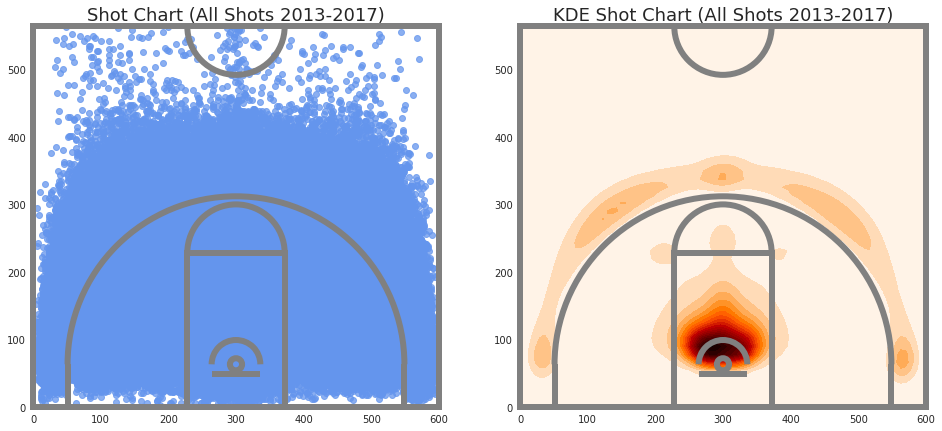

In [ ]:
# Adjust coordinates (convert to half-court, rotate 90 degrees)
df_query1 = df_full.select("team_basket", "event_coord_x", "event_coord_y")
df_query1_adj = adjust_coordinates(df_query1)

#  Convert to pandas dataframe 
df_plot_shot = df_query1_adj.toPandas()

# Visualize shots
sns.set_style('white')
sns.set_color_codes()
fig, ax = plt.subplots(1, 2, figsize=(16,7))

# Regular shot chart
title_ = "Shot Chart (All Shots 2013-2017)"
plt.subplot(1,2,1); shot_chart(df_plot_shot.x, df_plot_shot.y, title=title_)

# KDE shot chart
cmap=plt.cm.gist_heat_r
title_ = "KDE Shot Chart (All Shots 2013-2017)"
plt.subplot(1,2,2); shot_chart(df_plot_shot.x, df_plot_shot.y, kind="kde", title=title_, cmap=cmap, n_levels=20)

plt.show()

The regular shot chart (left) isn't particularly helpful. There are simply too many shots to be able to visualize any trends. The KDE shot chart (right), however, provides some useful information. Clearly, most NCAA shot attempts occur right near the basket. The next most frequent shot attempts occur around the three-point arc, at the elbows, and near the free-throw line. Next, I break these shots down by type, as documented by the variable `shot_type.`

### 5.2 &emsp; Breaking Down Shots by Type

Recall from the previous section that shot type isn't docmented until the 2014-15 season. The first step then is to get a list of the distinct shot types from the dataset, after excluding any observations from the 2013-14 season.

In [89]:
df_full.filter("season > 2013").select("shot_type").distinct()

shot_type
jump shot
layup
tip shot
hook shot
dunk


There are five valid shot types in this dataset:
1. *Jump shot* - occurs when a player jumps off the ground and releases their shot mid-air
2. *Layup* - occurs when a player uses one hand to bounce the ball off the backboard and into the basket
3. *Tip shot* - occurs when a player taps the ball into the basket
4. *Hook shot* - occurs when a player turns perpendicular to the basket and releases the ball with one hand in a sweeping motion over his head
5. *Dunk* - occurs when a player puts the ball directly through the hoop with hands over the rim

Because there is not already a shot type for three-point shot attempts, I create one myself. By separating jump shots where `three_point_shot` is *False* from jump shots where `three_point_shot` is *True*, I effectively split this category into two separate ones. The first represents two-point jump shots and the second represents three-point jump shots. After ensuring that there are now six different shot type categories, I calculate what percentage of all shot attempts is attributable to each shot type.

In [107]:
# Break it down by shot type
# Write SQL query
query_string = """
    SELECT shot_type, three_point_shot,
    COUNT(*) as count
    FROM df
    WHERE type = "fieldgoal"
      AND event_coord_x IS NOT NULL
      AND event_coord_y IS NOT NULL
      AND season > 2013
    GROUP BY shot_type, three_point_shot
    ORDER BY count DESC
"""

# Run query and save to Spark dataframe
df_query = spark.sql(query_string)

# Calculate percentages
df_query = df_query.withColumn('percent', f.col('count')/f.sum('count').over(Window.partitionBy()))
df_query.withColumn('percent', f.round(f.col('percent'), 2)).orderBy('percent', ascending=False)

shot_type,three_point_shot,count,percent
jump shot,true,382661,0.36
layup,false,337805,0.31
jump shot,false,297414,0.28
dunk,false,41997,0.04
tip shot,false,6117,0.01
hook shot,false,11015,0.01


Looking at the output, it is clear that three-point jump shots, layups, and two-point jump shots are the most popular shot types in the NCAA. Dunks, hook shots and tip shots occur far less frequently. This is not entirely surprising because all of those shots are usually performed by Centers, whereas the more popular shots can be performed by all players. Now that I know the general makeup of shots in the NCAA, I create KDE shot charts for each shot type individually to get a sense of what areas on the court they most frequently occur.

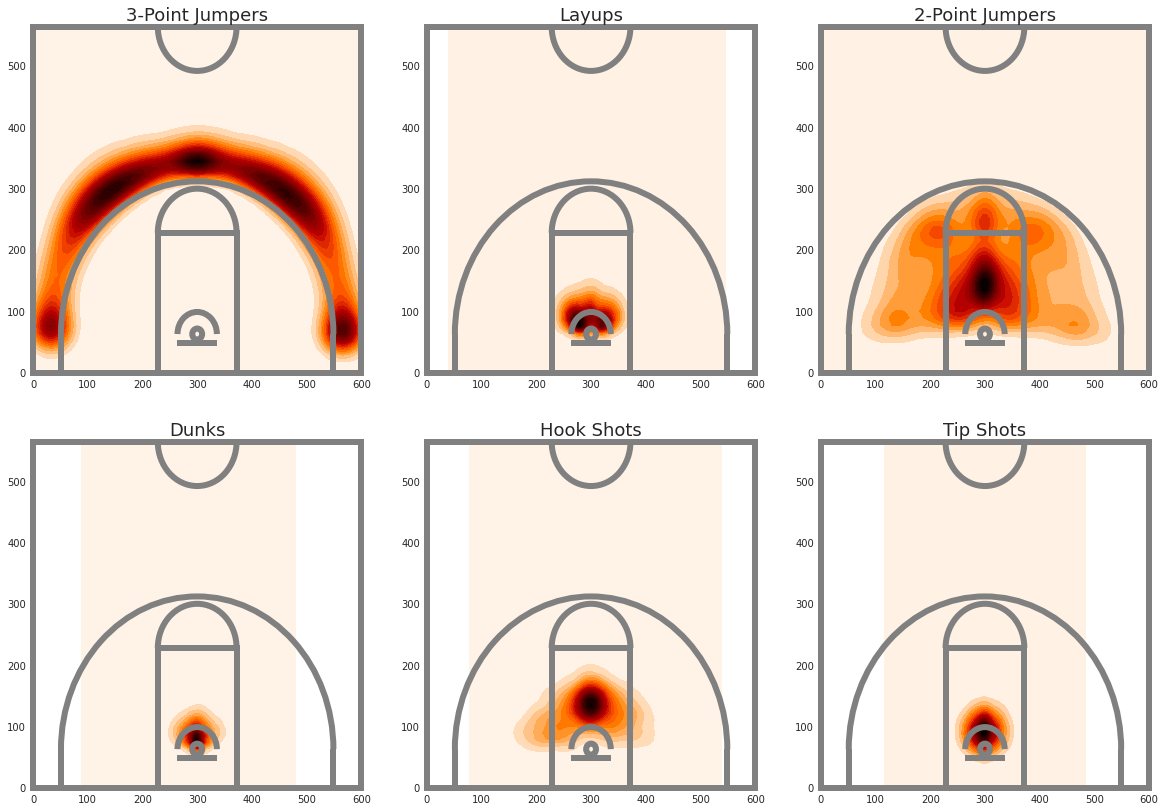

In [95]:
# Filter out 2013 season and keep only relevant columns
df_query2 = df_full.filter("season > 2013").\
                    select("shot_type", "three_point_shot", "team_basket", "event_coord_x", "event_coord_y")

# Adjust coordinates (convert to half-court, rotate 90 degrees)
df_query2_adj = adjust_coordinates(df_query2) 

# Create Pandas dataframes for each shot type
df_plot_shot_3jumpshot = df_query2_adj.filter("shot_type = 'jump shot' and three_point_shot = True").toPandas()
df_plot_shot_layup = df_query2_adj.filter("shot_type = 'layup'").toPandas()
df_plot_shot_2jumpshot = df_query2_adj.filter("shot_type = 'jump shot' and three_point_shot = False").toPandas()
df_plot_shot_dunk = df_query2_adj.filter("shot_type = 'dunk'").toPandas()
df_plot_shot_hookshot = df_query2_adj.filter("shot_type = 'hook shot'").toPandas()
df_plot_shot_tipshot = df_query2_adj.filter("shot_type = 'tip shot'").toPandas()

# Visualize shots
fig, ax = plt.subplots(2, 3, figsize=(20, 14))
plt.subplot(2,3,1); shot_chart(df_plot_shot_3jumpshot.x, df_plot_shot_3jumpshot.y, kind="kde", title="3-Point Jumpers", cmap=cmap, n_levels=20)
plt.subplot(2,3,2); shot_chart(df_plot_shot_layup.x, df_plot_shot_layup.y, kind="kde", title="Layups", cmap=cmap, n_levels=20)
plt.subplot(2,3,3); shot_chart(df_plot_shot_2jumpshot.x, df_plot_shot_2jumpshot.y, kind="kde", title="2-Point Jumpers", cmap=cmap, n_levels=20)
plt.subplot(2,3,4); shot_chart(df_plot_shot_dunk.x, df_plot_shot_dunk.y, kind="kde", title="Dunks", cmap=cmap, n_levels=20)
plt.subplot(2,3,5); shot_chart(df_plot_shot_hookshot.x, df_plot_shot_hookshot.y, kind="kde", title="Hook Shots", cmap=cmap, n_levels=20)
plt.subplot(2,3,6); shot_chart(df_plot_shot_tipshot.x, df_plot_shot_tipshot.y, kind="kde", title="Tip Shots", cmap=cmap, n_levels=20)
plt.show()

Analyzing each of the shot types separately provides a bit more insight into where players are shooting. The majority of three-point shots appear to come from the top of the arc as well as the corners. Two-point jumpers occur primarily in the paint, and a bit in the elbows and above the free-throw line as well. Layups, dunks and tip shots are all very close to the basket so its hard to really gain any insight there. While hook shots are a bit more spread out, the majority do occur right in front of the basket. With hook shots, though, a little bit of right-dominance does start to appear. The other shot types still appear fairly evenly distributed on both sides of the court. It would not be surprising if any asymmetry remains masked by the heavy volume of shots occuring right in front of the basket. 

### 5.3 &emsp; Breaking Down Shots by Season

Next, I separate shot attempts by season to see if there are any noticeable shooting trends over the years. The first step is to count the number of shot attempts per year to see if they are roughly equal.

In [133]:
# Break it down by season
# Write SQL query
query_string = """
    SELECT season,
    COUNT(*) as count
    FROM df
    WHERE type = "fieldgoal"
      AND event_coord_x IS NOT NULL
      AND event_coord_y IS NOT NULL
    GROUP BY season
    ORDER BY season
"""

# Run query and save to Spark dataframe
df_query = spark.sql(query_string)

# Calculate percentages
df_query = df_query.withColumn('percent', f.col('count')/f.sum('count').over(Window.partitionBy()))
df_query = df_query.orderBy('season').toPandas()
display(df_query.style.format({'percent': "{:.2%}"}))

,season,count,percent
0,2013,194962,15.33%
1,2014,258353,20.31%
2,2015,301515,23.70%
3,2016,255966,20.12%
4,2017,261175,20.53%


Looking at the output, the average number of shots per season is just over 250,000. Relative to the average, the number of shots for the 2013-14 season looks unusually low and the number of shots for the 2015-16 season looks unusually high. As a sanity check, I count the number of games in each season for which shot locations were recorded.

In [132]:
# Break it down by season
# Write SQL query
query_string = """
    SELECT season,
    COUNT(DISTINCT game_id) as count
    FROM df
    WHERE type = "fieldgoal"
      AND event_coord_x IS NOT NULL
      AND event_coord_y IS NOT NULL
    GROUP BY season
    ORDER BY season
"""

# Run query and save to Spark dataframe
df_query = spark.sql(query_string)

# Calculate percentages
df_query = df_query.withColumn('percent', f.col('count')/f.sum('count').over(Window.partitionBy()))
df_query = df_query.orderBy('season').toPandas()
display(df_query.style.format({'percent': "{:.2%}"}))

,season,count,percent
0,2013,1745,15.63%
1,2014,2375,21.28%
2,2015,2598,23.27%
3,2016,2210,19.80%
4,2017,2235,20.02%


The output here seems to explain the discrepancies with regards to the number of shots per season. Regardless, there are still enough shot attempts in each season for the shot distributions to be accurately represented. With this check complete, I create individual KDE shot charts for all five seasons.

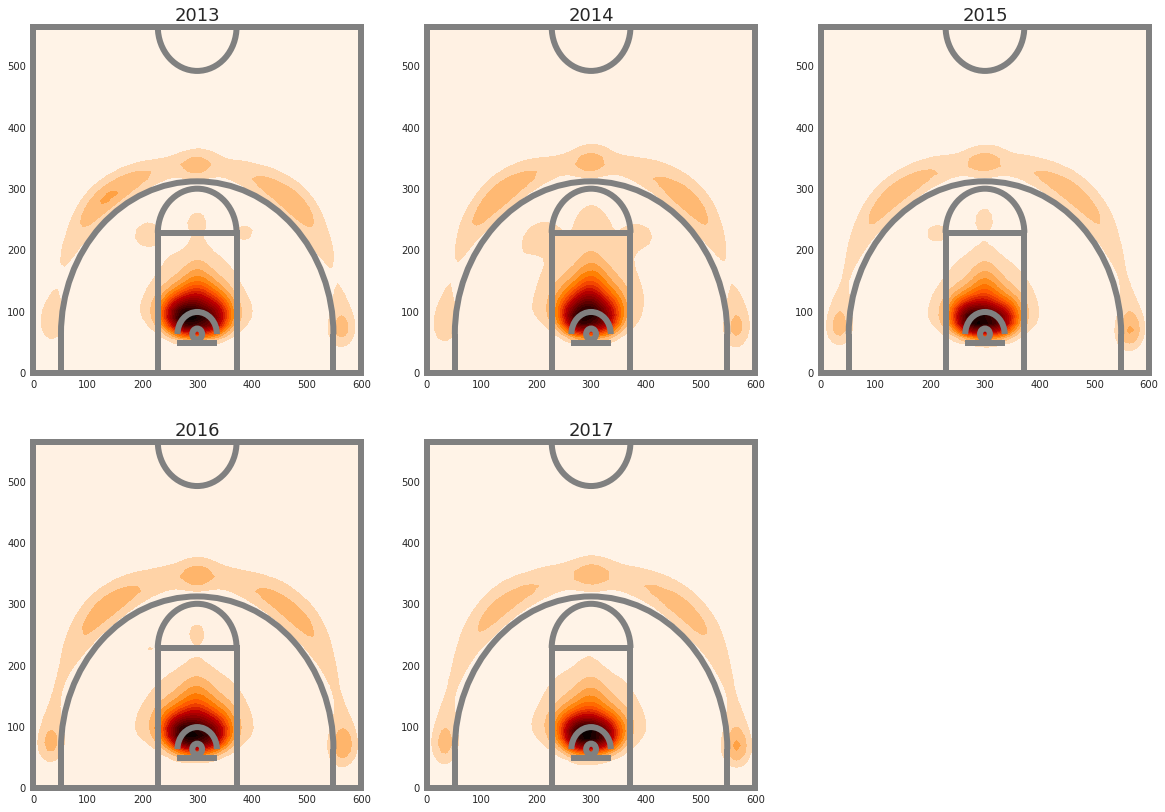

In [ ]:
# Keep only relevant columns 
df_query3 = df_full.select("season", "team_basket", "event_coord_x", "event_coord_y")

# Adjust coordinates (convert to half-court, rotate 90 degrees)
df_query3_adj = adjust_coordinates(df_query3)

# Create Pandas dataframes for each season
df_plot_shot_2013 = df_query3_adj.filter("season = 2013").toPandas()
df_plot_shot_2014 = df_query3_adj.filter("season = 2014").toPandas()
df_plot_shot_2015 = df_query3_adj.filter("season = 2015").toPandas()
df_plot_shot_2016 = df_query3_adj.filter("season = 2016").toPandas()
df_plot_shot_2017 = df_query3_adj.filter("season = 2017").toPandas()

# Visualize shots
fig, ax = plt.subplots(2, 3, figsize=(20, 14))
plt.subplot(2,3,1); shot_chart(df_plot_shot_2013.x, df_plot_shot_2013.y, kind="kde", title="2013", cmap=cmap, n_levels=20)
plt.subplot(2,3,2); shot_chart(df_plot_shot_2014.x, df_plot_shot_2014.y, kind="kde", title="2014", cmap=cmap, n_levels=20)
plt.subplot(2,3,3); shot_chart(df_plot_shot_2015.x, df_plot_shot_2015.y, kind="kde", title="2015", cmap=cmap, n_levels=20)
plt.subplot(2,3,4); shot_chart(df_plot_shot_2016.x, df_plot_shot_2016.y, kind="kde", title="2016", cmap=cmap, n_levels=20)
plt.subplot(2,3,5); shot_chart(df_plot_shot_2017.x, df_plot_shot_2017.y, kind="kde", title="2017", cmap=cmap, n_levels=20)
plt.delaxes(ax[1,2])
plt.show()

At first glance, all of these plots look pretty similar. But there are some interesting takeaways. The first is that over time, the frequency of three-point jump shots appears to increase. Additionally, there appears to be increasing frequency of the corner three-point shot. This is consistent with the "three-point revolution" that has taken over both the NCAA and the NBA during the past decade. The second takeaway is that the frequency of two-point jump shots (or "mid-range" shots) appears to decrease over the five-season period. Notice how shots taken at the elbows and on the free-throw line completely disappear by the 2017-18 season. This might mean that the increase in three-point shooting in the NCAA has come at the expense of mid-range shots.

### 5.4 &emsp; Breaking Down Shots by Type and Season

Next, I attempt to quantify the takeaways from the previous section by breaking down shots by both shot type and season.

In [135]:
# Write SQL query
query_string = """
    SELECT season,
    COUNT(CASE WHEN shot_type = "jump shot" AND three_point_shot THEN 1 END) / COUNT(shot_type) AS three_pt_shots_att, 
    COUNT(CASE WHEN shot_type = "jump shot" AND NOT three_point_shot THEN 1 END) / COUNT(shot_type) AS two_pt_shots_att, 
    COUNT(CASE WHEN shot_type = "layup" THEN 1 END) / COUNT(shot_type) AS layups_att,
    COUNT(CASE WHEN shot_type = "dunk" THEN 1 END) / COUNT(shot_type) AS dunks_att,
    COUNT(CASE WHEN shot_type = "hook shot" THEN 1 END) / COUNT(shot_type) AS hook_shots_att,
    COUNT(CASE WHEN shot_type = "tip shot" THEN 1 END) / COUNT(shot_type) AS tip_shots_att
    FROM df
    WHERE type = "fieldgoal"
      AND event_coord_x IS NOT NULL
      AND event_coord_y IS NOT NULL
      AND season > 2013
    GROUP BY season
    ORDER BY season
"""

# Run query and save to Spark dataframe
df_query = spark.sql(query_string).toPandas()
display(df_query.style.format({
    'three_pt_shots_att': "{:.2%}",
    'two_pt_shots_att': "{:.2%}",
    'layups_att': "{:.2%}",
    'dunks_att': "{:.2%}",
    'hook_shots_att': "{:.2%}",
    'tip_shots_att': "{:.2%}"}))

,season,three_pt_shots_att,two_pt_shots_att,layups_att,dunks_att,hook_shots_att,tip_shots_att
0,2014,33.71%,30.56%,31.85%,3.88%,0.00%,0.00%
1,2015,35.11%,28.96%,32.23%,3.70%,0.00%,0.00%
2,2016,36.01%,26.08%,30.66%,3.90%,2.18%,1.17%
3,2017,37.34%,24.65%,30.58%,4.15%,2.08%,1.20%


Looking at the output, it appears as though hook shots and tip shots were not recorded until the 2016-17 season. Since we know that these shots typically occur quite close to the basket, they were likely previously being grouped as either layups or two-point jump shots. This could help explain the drop in both of those categories over the five-season period. Regardless, these numbers appear to validate the trends I pointed out in the previous section. First, the percentage of three-point shot attempts has risen significantly over the five-season period. The subsequent drop in two-point jump shots gives some weight to the idea that these mid-range shots have become less favorable due to the rise of the "three-point revolution." Next, the relatively stable rates of layups, dunks, hook shots and tip shots (assuming that hook shots and tip shots were not recorded until the 2016-17 season) show that these shots are still strongly preferred, despite the increase in three-point shooting.

### 5.5 &emsp; Evaluating Field Goal Percentage by Shot Type

In this section, I try to investigate why mid-range shots in particular have become less popular in the wake of the "three-point revolution." I do so by evaluating shot success as the distance of a shot increases. First, I calculate overall shot success (or field goal percentage) in each season to see if the increase in three-point shooting has had any adverse effects.

In [144]:
# Write SQL query
query_string = """
    SELECT season,
    COUNT(CASE WHEN shot_made = True THEN 1 END) as made_shots,
    COUNT(*) as shot_attempts,
    COUNT(CASE WHEN shot_made = True THEN 1 END) / COUNT(*) as fg_pct
    FROM df
    WHERE type = "fieldgoal"
      AND event_coord_x IS NOT NULL
      AND event_coord_y IS NOT NULL
    GROUP BY season
    ORDER BY season
"""

# Run query and save to Spark dataframe
df_query = spark.sql(query_string).toPandas()
display(df_query.style.format({'fg_pct': "{:.2%}"}))

,season,made_shots,shot_attempts,fg_pct
0,2013,84878,194962,43.54%
1,2014,110676,258353,42.84%
2,2015,130982,301515,43.44%
3,2016,112286,255966,43.87%
4,2017,115793,261175,44.34%


Looking at the output, it appears that field goal percentage has held fairly constant over the years. We know from the previous section that the frequency of three-point shots increased, while the number of two-point jump shots decreased. Since field goal percentage has held constant, then perhaps the shot success for two-point jump shots and three-point jump shots are not very different (despite the fact that three-point jump shots are taken from a greater distance). To investigate further, I calculate field goal percentage by shot type.

In [158]:
# Write SQL query
query_string = """
    SELECT season,
    COUNT(CASE WHEN shot_made = True AND three_point_shot THEN 1 END) / COUNT(CASE WHEN three_point_shot THEN 1 END) as three_pct,
    COUNT(CASE WHEN shot_made = True AND shot_type = "jump shot" AND NOT three_point_shot THEN 1 END) / COUNT(CASE WHEN shot_type = "jump shot" AND NOT three_point_shot THEN 1 END) as two_pct,
    COUNT(CASE WHEN shot_made = True AND shot_type = "layup" THEN 1 END) / COUNT(CASE WHEN shot_type = "layup" THEN 1 END) as layup_pct,
    COUNT(CASE WHEN shot_made = True AND shot_type = "dunk" THEN 1 END) / COUNT(CASE WHEN shot_type = "dunk" THEN 1 END) as dunk_pct,
    COUNT(CASE WHEN shot_made = True AND shot_type = "hook shot" THEN 1 END) / COUNT(CASE WHEN shot_type = "hook shot" THEN 1 END) as hook_pct,
    COUNT(CASE WHEN shot_made = True AND shot_type = "tip shot" THEN 1 END) / COUNT(CASE WHEN shot_type = "tip shot" THEN 1 END) as tip_pct
    FROM df
    WHERE type = "fieldgoal"
      AND event_coord_x IS NOT NULL
      AND event_coord_y IS NOT NULL
      AND season > 2013
    GROUP BY season
    ORDER BY season
"""

# Run query and save to Spark dataframe
df_query = spark.sql(query_string).toPandas()
display(df_query.style.format({
    'three_pct': "{:.2%}",
    'two_pct': "{:.2%}",
    'layup_pct': "{:.2%}",
    'dunk_pct': "{:.2%}",
    'hook_pct': "{:.2%}",
    'tip_pct': "{:.2%}"}))

,season,three_pct,two_pct,layup_pct,dunk_pct,hook_pct,tip_pct
0,2014,33.86%,34.67%,54.67%,88.04%,nan%,nan%
1,2015,34.42%,35.53%,55.15%,88.96%,nan%,nan%
2,2016,35.00%,35.45%,54.76%,88.25%,48.72%,62.19%
3,2017,35.15%,36.56%,54.98%,88.90%,46.85%,60.29%


Unsurprisingly, the field goal percentage for dunks is extremely high. Dunks occur when a player essentially has no distance whatsoever between himself and the basket. Additionally, dunks are oftentimes not very heavily contested. Not far behind are tip shots, layups and hook shots. All of these shots primarily occur in the paint, so a relatively high field goal percentage is expected. Interestingly, the field goal percentage for two-point jump shots and three-point jump shots are almost the same, despite the fact that three-point jump shots occur from a greater distance. 

In order to examine this phenomenon on a more granular level, I use the (x,y)-coordinates to calculate shot distance (in feet) and round it to the nearest tenth. I filter out shots that were taken more than 30 feet from the basket, because the high infrequency of these shots would produce unstable field goal percentages. Then, I group the shots by distance and calcualte field goal percentage (or shot accuracy). Last, I plot the aggregated dataset to get an idea of how shot success changes as shots get farther away from the basket.   

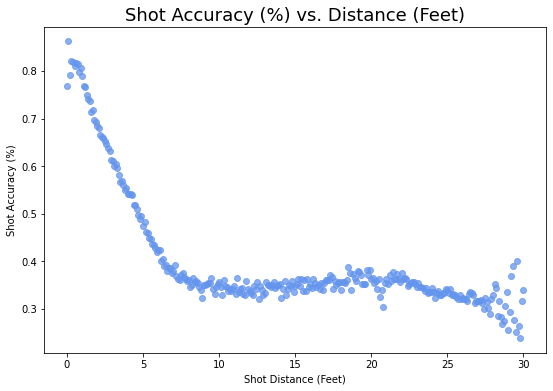

In [62]:
# Keep only relevant columns
df_query4 = df_full.select("event_coord_x", "event_coord_y", "team_basket", "shot_made")

# Adjust coordinates (convert to half-court, rotate 90 degrees)
df_query4_adj = adjust_coordinates(df_query4)                                  

# Calculate distance from basket, convert from inches to feet, and round to one decimal place
# RECALL: The basket is located at (300, 63)
df_query4_dist = df_query4_adj.withColumn("shot_distance", f.round(f.sqrt(f.pow(f.col("x") - 300, f.lit(2)) + f.pow(f.col("y") - 63, f.lit(2))) / 12, 1)). \
                            filter("shot_distance <= 30")

# Group by shot distance (to the nearest tenth), calculate shot accuracy, and convert to Pandas dataframe
df_plot_dist = df_query4_dist.groupBy("shot_distance"). \
                                agg(f.sum(f.when(f.col('shot_made') == True, 1)).alias('made_shots'), \
                                   f.count(f.lit(1)).alias("att_shots")). \
                                withColumn("shot_accuracy", f.col('made_shots') / f.col('att_shots')). \
                                orderBy("shot_distance"). \
                                toPandas()

# Create scatter plot
plt.rcParams['figure.figsize'] = (9, 6)
plt.scatter(df_plot_dist.shot_distance, df_plot_dist.shot_accuracy, alpha=0.75, c = 'cornflowerblue')
plt.xlabel("Shot Distance (Feet)"); plt.ylabel("Shot Accuracy (%)")
plt.title("Shot Accuracy (%) vs. Distance (Feet)", fontsize=18)
plt.show()

Looking at the scatter plot, the first thing that I notice is a clear drop in shooting accuracy between zero and five feet from the basket. This is expected, because shots occurring zero feet from the basket are mostly dunks. We know from earlier that close to 90% of dunk attempts are successful. Shots taken closer to five feet from the basket could be either layups, hook shots, tip shots, or two-point jump shots. It makes sense, then, that the shot accuracy falls between 40-50%. Now, while the plot does exhibit a largely decreasing trend, it actually levels out in the middle (particularly in the 10-20 foot range). This offers some support for the increase in three-point shooting in the NCAA. If the chances of making a two-point shot and a three-point shot are roughly the same, it makes sense to shoot the three-point shot. 

Unfortunately, without taking into account other information (particularly how different shots are defended), it is hard to draw any definitive conclusions here. One could argue that shooting beyond the three-point arc gives the shooter the ability to put more space between themselves and their defender, thus increasing the likelihood that the shot goes in. Regardless, it is an interesting takeaway that does inform what to expect from the results of the analysis in Section 6. Based on the brief exploratory analysis in this section, I would not be surprised if the first few spatial components were comprised of three-point shots and shots close to the basket. Additionally, when comparing the spatial components over the five-season period, I would also expect to see a decreasing preference for longer two-point jump shots.

## 6 &emsp; Non-Negative Matrix Factorization

In the following section, I apply non-negative matrix factorization (NMF) to uncover the underlying structure of NCAA player shooting distributions. I detail the methodological steps taken to prepare the data for matrix factorization. Additionally, I explore the application of NMF using several different approaches and offer a comparison of the resulting basis vectors.

### 6.1 &emsp; Methodological Procedure

In order to apply NMF on this dataset, I must first transform my data into a matrix, where each row represents a player and each column represents the number of shots taken in a particular location on the court. In the original dataset, each row represents a unique shot attempt. My first step, then, is to aggregate all of the shots for each player. To do so, I create a function `aggregate_shots()`. In this function, I group all of the rows by `player_id` and, in the process, condense all of a player's shots into two lists. The first contains the $x$-coordinates of each shot and the second contains the $y$-coordinates of each shot. Additionally, I create a new variable which counts the total number of shots each player has taken. The last step in this function is to then exclude any players with fewer than 50 shot attempts. I do this because the shot distribution for a player with only a few shot attempts is likely to be unreliable.

In [56]:
def aggregate_shots(df):
    
    """Returns a Spark DataFrame where each player's shots have been
    aggregated into two lists (one with the x-coordinates and a second
    with the y-coordinates). Additionally, players with fewer than 50 
    shots are filtered out.
    
    Parameters
    ----------
    df: Spark DataFrame containing (at the very least) the following
    columns: (1) "player_id"; (2) "team_alias"; (3) "player_full_name"; 
    (4) "x"; and (5) "y".
    
    Returns
    -------
    df_agg_filtered: Spark DataFrame that has been grouped by Player
    ID and aggregated the (x,y)-coordinates for each player's shots.
    Additionally, players with fewer than 50 shows are excluded. This
    DataFrame contains an additional column "num_shots".
    """
    
    # Create aggregated dataframe:
    # (1) Group by player id
    # (2) Collect each player's (x,y)-coordinates into two lists
    # (3) Calcualte each player's total number of shots
    df_agg = df.groupBy("player_id"). \
                agg(f.concat_ws(",", f.collect_set("team_alias")).alias("team_alias"), \
                    f.concat_ws(",", f.collect_set("player_full_name")).alias("player_full_name"), \
                    f.collect_list("x").alias("x"), \
                    f.collect_list("y").alias("y"), \
                    f.count(f.lit(1)).alias("num_shots"))
    
    # Remove players with fewer than 50 shot attempts
    df_agg_filtered = df_agg.filter("num_shots >= 50")

    return df_agg_filtered    

In the next step, I create a raw shot count vector for each player by discretizing the court into distinct 6" x 6" bins and calculating the number of shots taken in each bin location. Bins of this size are sufficiently small to capture the interesting spatial variation in my dataset. To complete this step, I create a UDF function which gives me the ability to apply functions from the *numpy*, *scipy* and *sklearn* libraries directly to Spark DataFrame columns. 

Within this function, called `udf_bin_shot_counts`, the first steps is to define the bin edges for the $x$-dimension and the $y$-dimension. As discussed in Section 4, the length of the court is 1,128 inches (making the length of the half-court equal to 564 inches) and the width is 600 inches. Because I have chosen to move all of the shots to the left side of the court and rotate them 90 degrees, this means that the $x$-coordinates for a shot can range anywhere from 0" to 600" and the $y$-coordinates can range anywhere from 0" to 564". As a result, dividing the court into 6" x 6" sections reuires 100 bins in the $x$-dimension and 94 bins in the $y$-dimension. 

Once the bin edges are defined, I create a two-dimensional histogram for every player individually that calculates their shot frequency at each bin location. This results in a matrix with 100 rows and 94 columns. I then vectorize the matrix to create a shot count vector (resulting in an array with $100 \times 94 = 9,400$ elements). In order to make the results compatible with Spark DataFrames, I then transform the count vector into a dense vector, as supported by Spark's *MLlib* library.

In [76]:
@f.udf(VectorUDT())
def udf_bin_shots_counts(xcol, ycol):
    
    """Returns a vectorized two-dimensional histogram representing the 
    frequency of a player's shots in all different locations on the court. 
    The histogram is created by doing the following: (1) the court is 
    binned into 6" x 6" squares; (2) the 2D histogram is created by 
    counting (for each player) the number of shots taken in each bin; 
    (3) the histogram is then vectorized and converted into a dense 
    vector in order to be compatible with Spark DataFrames.
    
    Parameters
    ----------
    xcol: List, column, or vector or numpy array containing the 
    x-coordinates of a player's shots.
    ycol: List, column, vector or numpy array containing the
    y-coordinates of a player's shots.
    
    Returns
    -------
    Vectors.dense(binned_vector): Vectorized version of
    the two-dimensional histogram.    
    """
    
    # Convert x and y to numpy arrays
    x = np.array(xcol)
    y = np.array(ycol)
    
    # Define bin edge definitions in inches
    xedges = (np.linspace(start=0, stop=600, num=100+1, dtype=np.float))
    yedges = (np.linspace(start=0, stop=564, num=94+1, dtype=np.float))
    
    # Create two-dimensional histogram
    binned, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
     
    # Vectorize the bins
    binned_vector = binned.reshape(-1)
            
    return Vectors.dense(binned_vector)

The function `udf_bin_shots_counts()` is used for applying NMF directly to the raw shot count matrix. In addition to this approach, I also want to apply NMF to a smoothed shot count matrix. To do so, I create another function `udf_bin_shots_smooth().` Unfortuntely, I must define both functions separately, rather than combining them into one function with a keyword argument specification, because udfs do not yet support the use of keyword arguments.

The function `udf_bin_shots_smooth()` operates much the same as `udf_bin_shots_counts()` in terms of creating a two-dimensional histogram with a player's shot frequency at each bin location. In this function, however, I take the 100 x 94 matrix and pass it through a multidimensional Gaussian filter. I specify $\sigma$, or the standard deviation of the Gaussian kernel, to be 2 for both axes. I choose $\sigma = 2$ to reduce any unnecessary noise without the image becoming too blurred. Next, I vectorize the matrix (creating a smoothed shot count vector) and then normalize it so that all of the elements sum to one. I choose to normalize the data to account for the fact that some players take significantly more shots than others, and I do not want this to unduly influence the resulting basis vectors.

In [65]:
@f.udf(VectorUDT())
def udf_bin_shots_smooth(xcol, ycol):
    
    """Returns a vectorized two-dimensional histogram representing the 
    frequency of a player's shots in all different locations on the court. 
    The histogram is created by doing the following: (1) the court is 
    binned into 6" x 6" squares; (2) the 2D histogram is created by 
    counting (for each player) the number of shots taken in each bin;
    (3) the histogram is then smoothed using a kernel smoothing algorithm;
    (4) the histogram is also normalized so that all of the entries in 
    each row sum to one; (5) the histogram is then vectorized and converted
    into a dense vector in order to be compatible with Spark DataFrames.
    
    Parameters
    ----------
    xcol: List, column, or vector or numpy array containing the 
    x-coordinates of a player's shots.
    ycol: List, column, vector or numpy array containing the
    y-coordinates of a player's shots.
    
    Returns
    -------
    Vectors.dense(binned_vector): Vectorized version of
    the two-dimensional histogram.    
    """
    
    # Convert x and y to numpy arrays
    x = np.array(xcol)
    y = np.array(ycol)
    
    # Define bin edge definitions in inches
    xedges = (np.linspace(start=0, stop=600, num=100+1, dtype=np.float))
    yedges = (np.linspace(start=0, stop=564, num=94+1, dtype=np.float))
    
    # Create two-dimensional histogram
    binned, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
    
    # Smooth the player's histogram using a multidimensional gaussian filter
    binned = ndimage.filters.gaussian_filter(binned, sigma=2)
    
    # Vectorize the bins
    binned_vector = binned.reshape(-1)
    
    # Normalize the player's histogram
    binned_vector = normalize(binned_vector[:,np.newaxis], axis=0, norm='l1').ravel()    
    
    return Vectors.dense(binned_vector)

Once I have created each player's shot count vector, it is straightforward to create the full shot count matrix. The next function, called `apply_nmf()`, takes this shot count matrix and applies NMF using the `NMF()` function from *sklearn.* The function returns both the basis matrix $W$ and the coefficient matrix $H$. This function has a number of different parameters, allowing the user to specify intialization action, cost function, and solver, to name a few. This will be discussed in more detail during the implementation in Section 6.2.

In [59]:
def apply_nmf(X, n_components=10, init='nndsvda', solver='mu',
              beta_loss='frobenius', max_iter=500, random_state=0):
    
    """Returns two non-negative matrices (W, H) whose product 
    approximates the non-negative matrix X.
    
    Parameters
    ----------
    X: Data matrix to be decomposed, with shape (n_samples, n_features).
    n_components: Number of components.
    init: Method used to initialize the procedure (random, nndsvd, nndsvda or nndsvdar).
    solver: Numerical solver to use (cd or mu).
    beta_loss: Beta divergence to be minimized (frobenius or kullback-leibler).
    max_iter: Maximum number of iterations before timing out.
    random_state: If int, random_state is the seed used by the random number generator.
    
    Returns
    -------
    W: Basis matrix, with shape (n_samples, n_components).
    H: Coefficient matrix, with shape (n_components, n_features).
    """
    
    # Create the model
    model = skld.NMF(n_components=n_components, init=init, solver=solver, \
                     beta_loss=beta_loss, max_iter=max_iter, random_state=random_state)
    
    # Extract the basis matrix W, with dimensions (n_samples, n_components)
    W = model.fit_transform(X)
    
    # Extract the coefficient matrix H, with dimensions (n_components, n_features)
    H = model.components_
    
    return W, H

The final function I have written, called `plot_spatial_components()`, works together with the `draw_court()` function defined previously to create a heatmap visualization of the spatial basis vectors discovered by NMF. The parameters vmin and vmax serve to anchor the plot's colormap. 

In [60]:
def plot_spatial_components(hist_counts, xedges, yedges, ax=None, 
                            court_color="gray", court_lw=6, cmap='jet', 
                            xlim=(0, 600), ylim=(0, 1128/2), title="",
                            vmin=0., vmax=0.005):
    
    """Plots a two-dimensional heatmap from non-negative matrix factorization output
    
    Parameters
    ----------
    hist_counts: Vectorized output from non-negative matrix factorization.
    xedges: Bin edge definition in inches.
    yedges: Bin edge definition in inches.
    ax: The Axes object to plot the court onto.
    court_color: The color of the court lines.
    court_lw: The linewidth the of the court lines.
    cmap: Colormap for the range of data values.
    xlim: The x-axis limits of the plot.
    ylim: The y-axis limits of the plot.
    title: The title for the plot.
    vmin, vmax: Parameters for anchoring the colormap.
    
    Returns
    -------
    ax: The Axes object with the shot chart heatmap plotted on it.
    """  
                   
    if ax is None:
        ax = plt.gca()
     
    # Set the x-axis and y-axis limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set title and remove tick marks
    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)
    
    # Create a rectangular grid out of xedges and  yedges
    X, Y = np.meshgrid(xedges, yedges)
    
    # Reshape the histogram counts with 100 rows and 94 columns
    counts = hist_counts.reshape((xedges.size-1,  yedges.size-1))
    
    # Generate the heatmap
    ax.pcolormesh(X, Y, counts.T, cmap=cmap, vmin=vmin, vmax=vmax)
    
    # Call the draw_court() function
    draw_court(ax, color=court_color, lw=court_lw)
    
    # Set the spines to match the rest of court lines
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(court_color)
    
    return(ax)

### 6.2 &emsp; Comparing Different NMF Decompositions

In this section, I discuss the implementation of several different NMF alternatives using the functions I have just created. First, I create a dataset which contains all of the shots taken during the 2017-18 season and select only the necessary columns.

In [77]:
# Write SQL query
query_string = """
    SELECT team_alias,
    team_basket,
    player_id,
    player_full_name,
    event_coord_x,
    event_coord_y,
    shot_made
    FROM df
    WHERE type = "fieldgoal"
        AND event_coord_x IS NOT NULL
        AND event_coord_y IS NOT NULL
        AND season = 2017
"""

# Run query and save to Spark dataframe
df_shots = spark.sql(query_string)
df_shots.limit(5)

team_alias,team_basket,player_id,player_full_name,event_coord_x,event_coord_y,shot_made
L-IL,right,f7d19d53-cb05-44f...,Bruno Skokna,1009.0,318.0,false
L-IL,right,0113c9c0-e95d-447...,Aundre Jackson,1050.0,356.0,true
L-IL,left,0113c9c0-e95d-447...,Aundre Jackson,95.0,219.0,true
L-IL,left,0113c9c0-e95d-447...,Aundre Jackson,130.0,267.0,true
L-IL,left,27e04f29-34a1-4f8...,Ben Richardson,79.0,241.0,true


Next, I call the function `adjust_coordinates()` to move all of the shots to the left side of the court and rotate them 90 degrees. Additionally, I call the function `aggregate_shots()` to group all of the $(x,y)$-coordinates by player and filter out any players with fewer than 50 shot attempts. The aggregated dataset contains a total of 215,962 shots distributed among 1,320 unique NCAA players.

In [78]:
# Adjust the (x,y)-coordinates
df_shots_adj = adjust_coordinates(df_shots)                                  

# Aggregte each player's shot attempts and remove any player with fewer than 50 shot attempts
df_shots_agg = aggregate_shots(df_shots_adj)
df_shots_agg.limit(5)

player_id,team_alias,player_full_name,x,y,num_shots
195cbc04-78e4-4a1...,YALE,Alex Copeland,"[267.0, 271.0, 26...","[240.0, 332.0, 33...",53
2f99409d-78ee-487...,AFA,CJ Siples,"[540.0, 312.0, 27...","[199.0, 88.0, 71....",67
5b2b73a2-882e-410...,GB,Khalil Small,"[136.0, 254.0, 35...","[70.0, 203.0, 84....",51
75b73e0d-a5fa-427...,NEV,Hallice Cooke,"[30.0, 179.0, 289...","[46.0, 320.0, 64....",118
aa2a0a13-e376-4f7...,DUQ,Eric Williams Jr.,"[367.0, 467.0, 35...","[334.0, 325.0, 10...",163


In [79]:
# Print the total number of players and total number of shots
print("Number of Players: ", df_shots_agg.count())
print("Number of Shots: ", df_shots_agg.agg({"num_shots":"sum"}).collect()[0][0])

Number of Players:  1320
Number of Shots:  215962


Now that my dataset has been aggregated, I apply the udf functions `udf_bin_shots_smooth()` and `udf_bin_shots_counts()` to each column in the DataFrame individually. The first new column, called *binned_smooth*, contains each player's smoothed and normalized shot count vector. The second column, called *binned_counts*, contains each player's raw shot count vector. Both vectors have 9,400 elements, which corresponds to the total number of bin locations. For a visual demonstration of the smoothing process, refer to Section 6.3 below.

Next, I transform these columns into two 1,320 x 9,400 shot matrices, where each row contains the shot count vector for an individual player. At the same time, I create a player index, which contains some information such as player name, player id, team name, and number of shots. The player index will be used again after the application of NMF in order to map each player to their corresponding basis weights.

In [80]:
# Create the two-dimensional histograms for each player's shots:
# (1) Smoothed/Normalized and (2) Just the raw counts
df_shots_binned = df_shots_agg.withColumn("binned_smooth", udf_bin_shots_smooth("x", "y")). \
                                withColumn("binned_counts", udf_bin_shots_counts("x", "y"))

# Convert to a Pandas dataframe
tmp = df_shots_binned.select("player_id", "team_alias", "player_full_name", "num_shots", "binned_smooth", "binned_counts").toPandas()

# Convert each row to a numpy array
tmp['binned_smooth'] = tmp['binned_smooth'].apply(lambda x: np.array(x))
tmp['binned_counts'] = tmp['binned_counts'].apply(lambda x: np.array(x))

# Create a player index
player_idx = tmp[["player_id", "team_alias", "player_full_name", "num_shots"]]

# Create the shot matrix (smoothed/normalized bins and raw counts)
shot_matrix_smooth = np.array(tmp.binned_smooth.tolist())
shot_matrix_counts = np.array(tmp.binned_counts.tolist())
print("Dimensions of Shot Matrix: ", np.shape(shot_matrix_smooth))

Dimensions of Shot Matrix:  (1320, 9400)


I have chosen to compare the results of three different approaches to NMF. The first two approaches (referred to as "Smooth-NMF") factorize the smoothed and normalized shot count matrix, but minimize different cost functions. In the first approach I minimize the Frobenius norm and in the second approach I minimize the Kullback-Leibler (KL) divergence. In the last approach (referred to as "Direct NMF"), I directly factorize the raw shot count matrix. Again, I choose to minimize the Kullback-Leibler (KL) divergence. For all three approaches, I have decided to use the multiplicative update rules to minimize my cost function. For initialization I use 'nndsvda,' a variation of Nonnegative Double Singular Value Decomposition (NNDSVD) in which all zeros are filled with the average of the original data matrix $V$. This is the recommended initialization method for when sparsity is not desired. Following the guidance from Miller *et al.* (2014), I have chosen the number of components $K=10$ [3]. This number of basis vectors is large enough to encompass the wide variation in shot selection among NCAA players, but not so large that we start seeing significant amounts of overlap. 

In [81]:
# Smooth-NMF (Frobenius)
W_Fr, H_Fr = apply_nmf(shot_matrix_smooth, n_components=10, beta_loss='frobenius')

# Smooth-NMF (KL)
W_KL, H_KL = apply_nmf(shot_matrix_smooth, n_components=10, beta_loss='kullback-leibler')

# Direct NMF (KL)
W_Raw, H_Raw = apply_nmf(shot_matrix_counts, n_components=10, beta_loss='kullback-leibler')

# Print the dimensions of the resulting matrices W and H
print("Dimensions of W: ", np.shape(W_Fr))
print("Dimensions of H: ", np.shape(H_Fr))

Dimensions of W:  (1320, 10)
Dimensions of H:  (10, 9400)


The result of each NMF application is a basis matrix $W$, with 1,320 rows and 10 columns, and a coefficient matrix $H$, with 10 rows and 9,400 columns. Using the `plot_spatial_components()` function defined in the previous section, I create a visual comparison of the resulting basis vectors from each approach.

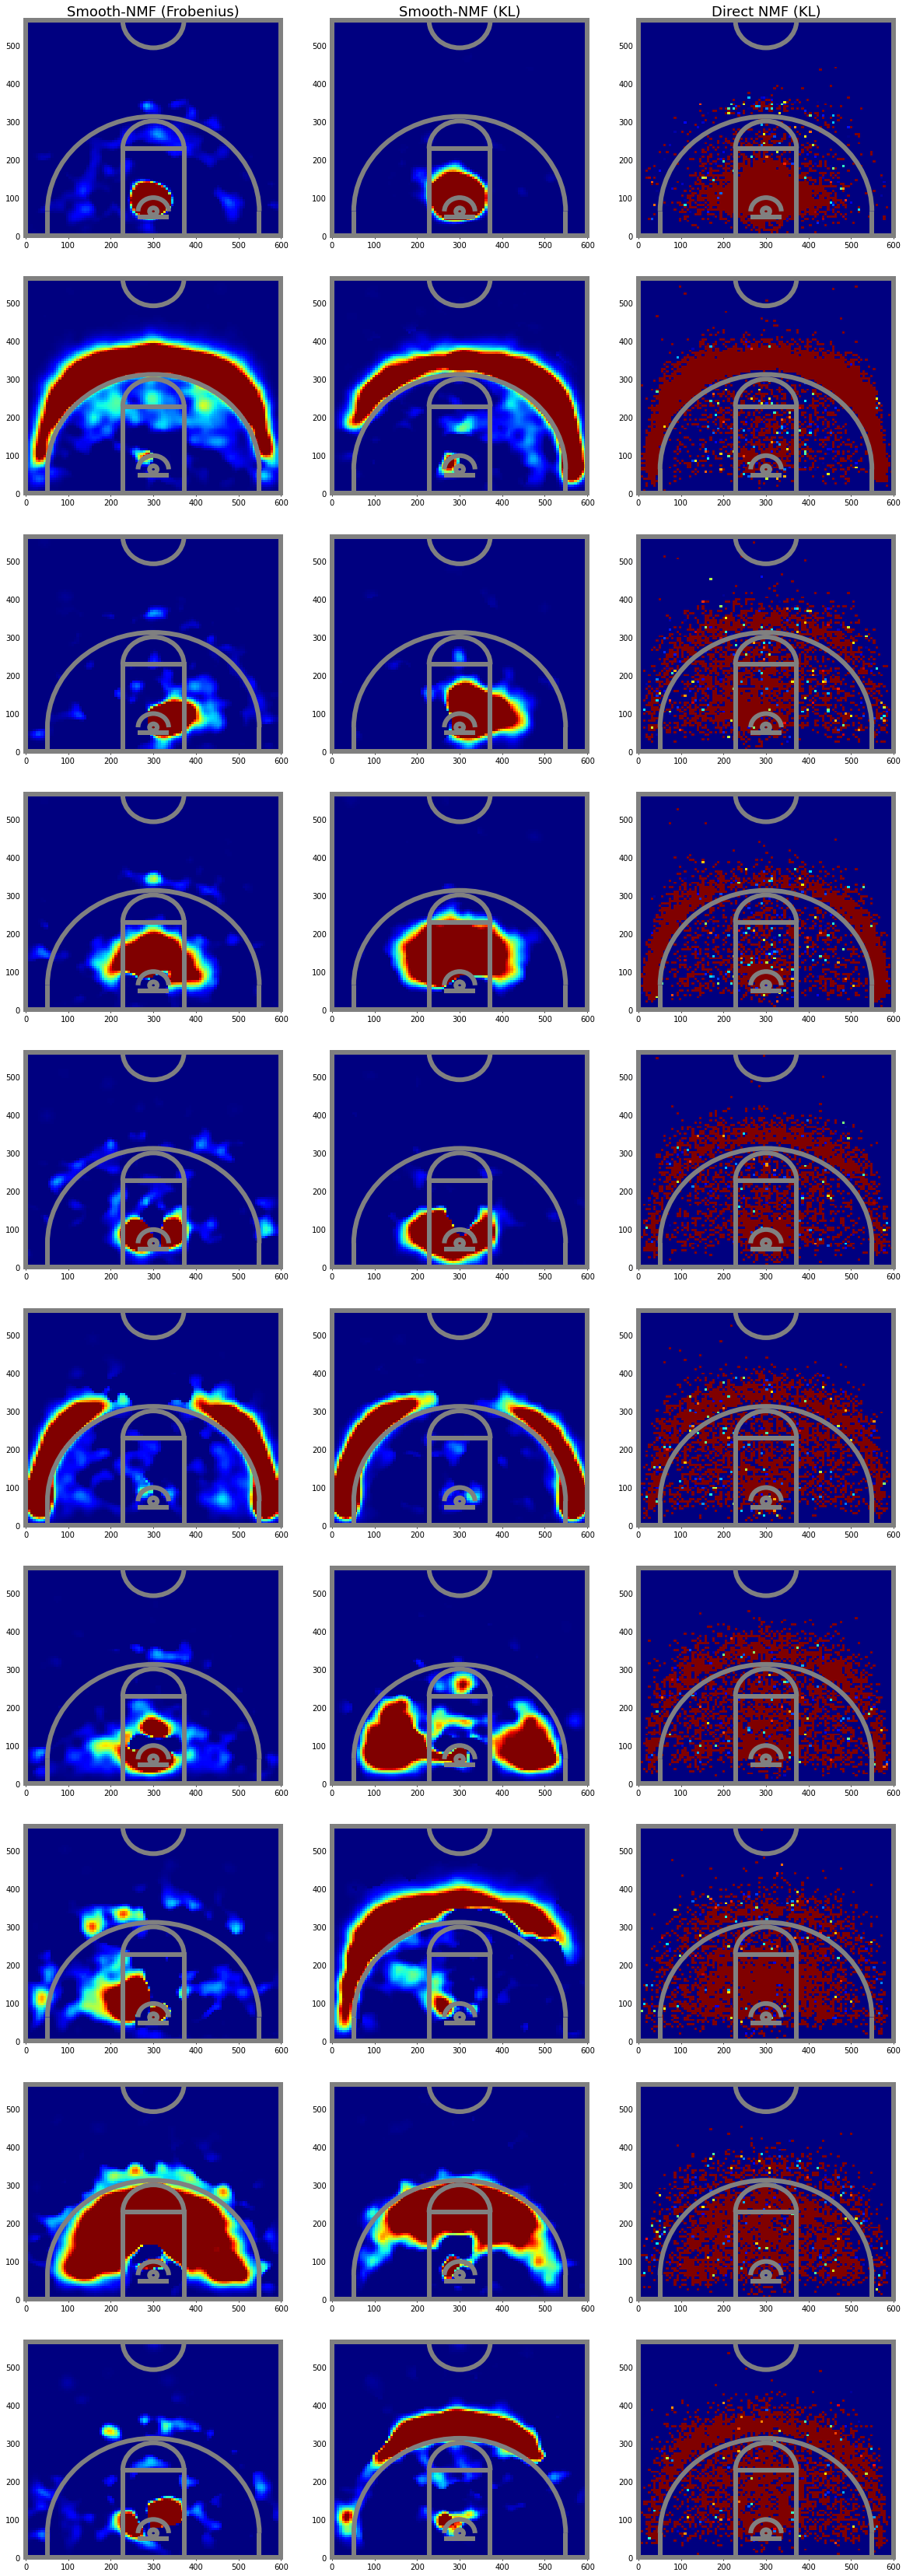

In [82]:
# Visualize the results
fig, ax = plt.subplots(10, 3, figsize=(20,60))

# Define bin edge definitions in inches
xedges = (np.linspace(start=0, stop=600, num=100+1, dtype=np.float))
yedges = (np.linspace(start=0, stop=564, num=94+1, dtype=np.float))

# Smooth-NMF (Frobenius)
plt.subplot(10,3,1); plot_spatial_components(H_Fr[0,:], xedges, yedges, title="Smooth-NMF (Frobenius)")
plt.subplot(10,3,4); plot_spatial_components(H_Fr[1,:], xedges, yedges)
plt.subplot(10,3,7); plot_spatial_components(H_Fr[2,:], xedges, yedges)
plt.subplot(10,3,10); plot_spatial_components(H_Fr[3,:], xedges, yedges)
plt.subplot(10,3,13); plot_spatial_components(H_Fr[4,:], xedges, yedges)
plt.subplot(10,3,16); plot_spatial_components(H_Fr[5,:], xedges, yedges)
plt.subplot(10,3,19); plot_spatial_components(H_Fr[6,:], xedges, yedges)
plt.subplot(10,3,22); plot_spatial_components(H_Fr[7,:], xedges, yedges)
plt.subplot(10,3,25); plot_spatial_components(H_Fr[8,:], xedges, yedges)
plt.subplot(10,3,28); plot_spatial_components(H_Fr[9,:], xedges, yedges)

# Smooth-NMF (KL)
plt.subplot(10,3,2); plot_spatial_components(H_KL[0,:], xedges, yedges, title="Smooth-NMF (KL)")
plt.subplot(10,3,5); plot_spatial_components(H_KL[1,:], xedges, yedges)
plt.subplot(10,3,8); plot_spatial_components(H_KL[2,:], xedges, yedges)
plt.subplot(10,3,11); plot_spatial_components(H_KL[3,:], xedges, yedges)
plt.subplot(10,3,14); plot_spatial_components(H_KL[4,:], xedges, yedges)
plt.subplot(10,3,17); plot_spatial_components(H_KL[5,:], xedges, yedges)
plt.subplot(10,3,20); plot_spatial_components(H_KL[6,:], xedges, yedges)
plt.subplot(10,3,23); plot_spatial_components(H_KL[7,:], xedges, yedges)
plt.subplot(10,3,26); plot_spatial_components(H_KL[8,:], xedges, yedges)
plt.subplot(10,3,29); plot_spatial_components(H_KL[9,:], xedges, yedges)

# Direct NMF (KL)
plt.subplot(10,3,3); plot_spatial_components(H_Raw[0,:], xedges, yedges, title="Direct NMF (KL)")
plt.subplot(10,3,6); plot_spatial_components(H_Raw[1,:], xedges, yedges)
plt.subplot(10,3,9); plot_spatial_components(H_Raw[2,:], xedges, yedges)
plt.subplot(10,3,12); plot_spatial_components(H_Raw[3,:], xedges, yedges)
plt.subplot(10,3,15); plot_spatial_components(H_Raw[4,:], xedges, yedges)
plt.subplot(10,3,18); plot_spatial_components(H_Raw[5,:], xedges, yedges)
plt.subplot(10,3,21); plot_spatial_components(H_Raw[6,:], xedges, yedges)
plt.subplot(10,3,24); plot_spatial_components(H_Raw[7,:], xedges, yedges)
plt.subplot(10,3,27); plot_spatial_components(H_Raw[8,:], xedges, yedges)
plt.subplot(10,3,30); plot_spatial_components(H_Raw[9,:], xedges, yedges)

plt.show()

This plot compares the resulting basis vectors for Smooth-NMF with the Frobenius (left) and KL (middle) loss functions, as well as for the Direct NMF (right). While both Smooth-NMF decomposition results look quite similar, the KL-based NMF decomposition exhibits a bit more spatial diversity. The Frobenius-based NMF decomposition, on the other hand, focuses quite heavily on shots close to the basket. In comparison to the Smooth-NMF decomposition results, those of the Direct NMF are almost unintelligible. Beyond the first two components, the results seem to lack any real spatial structure. This result is useful, however, in showing the significant difference that smoothing and normalizing the shot matrix can make.

### 6.3 &emsp; Smoothing the Shot Count Matrix

In this section, I create a visual depiction of player representations during each stage of the analysis. I will show the player representations for Trae Young and Mikal Bridges, two of the top NBA prospects during the 2017-18 NCAA season. This provides a "behind-the-scenes" look at the effect of each step that goes into creating the smooth and normalized shot matrix, as well as applying NMF. 

To create this visualization, I first need to calculate the NMF reconstructed surfaces for both players. I am able to do this by locating their respective weights in the $W$ matrix, and multiplying them by the $H$ matrix to create a vector with 9,400 elements (corresponding to the total number of bin locations). Once this is done, I also aggregate the data for each player's made and missed shots, their raw shot count vectors, and their smoothed and normalized shot count vectors.

In [89]:
# Turn the W matrix into a Pandas dataframe
W_df = pd.DataFrame(W_KL)

# Locate the indices for Trae Young and Mikal Bridges
idx_TY = player_idx.index[player_idx['player_full_name'] == "Trae Young"].tolist()
idx_MB = player_idx.index[player_idx['player_full_name'] == "Mikal Bridges"].tolist()

# Subset the W dataframe to include just the coefficients for each player
coeff_TY_df = W_df.loc[idx_TY,:]
coeff_MB_df = W_df.loc[idx_MB,:]

# Convert back into a numpy array
coeff_TY = np.array(coeff_TY_df)
coeff_MB = np.array(coeff_MB_df)

# Print the dimensions of these coefficient arrays
print(np.shape(coeff_TY))

# Calclate reconstructed surfaces for each player
reconstructed_TY = coeff_TY.dot(H_KL)
reconstructed_MB = coeff_MB.dot(H_KL)

# Print the dimensions of the reconstructed surfaces
print(np.shape(reconstructed_TY))

(1, 10)
(1, 9400)


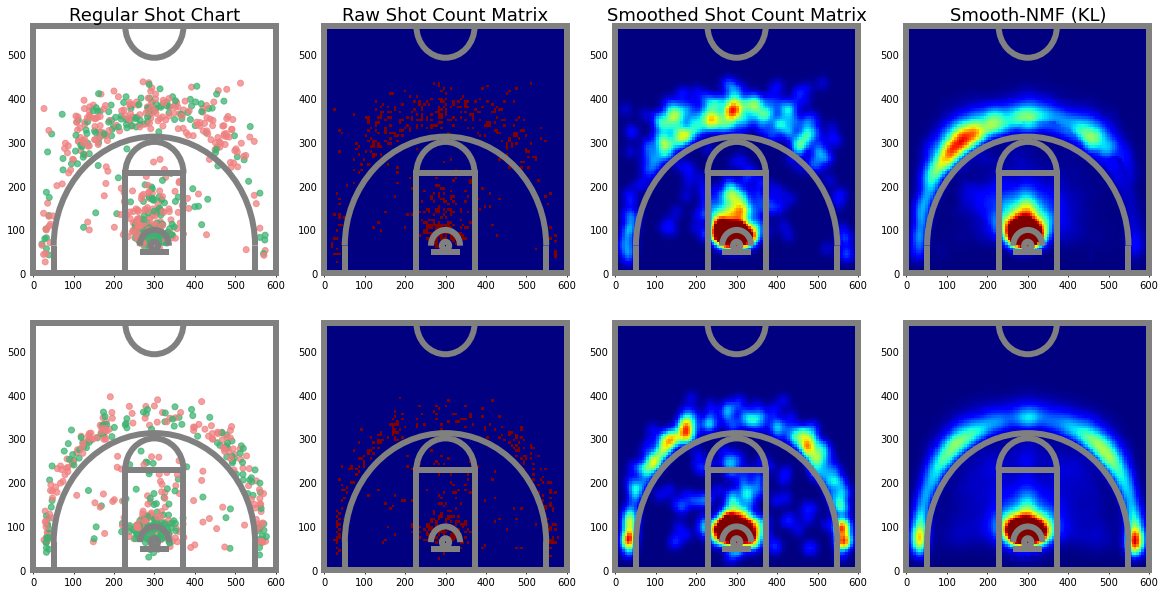

In [90]:
# Raw shot data - Trae Young and Mikal Bridges
df_shots = df_full.filter("season = 2017").select("player_full_name", "event_coord_x", "event_coord_y", "team_basket", "shot_made")
df_shots_adj = adjust_coordinates(df_shots)
df_trae_young = df_shots_adj.filter("player_full_name = 'Trae Young'").toPandas()
df_mikal_bridges = df_shots_adj.filter("player_full_name = 'Mikal Bridges'").toPandas()

# Raw shot count matrix - Trae Young and Mikal Bridges
bins_trae_young = tmp[tmp['player_full_name'] == "Trae Young"]
bins_mikal_bridges = tmp[tmp['player_full_name'] == "Mikal Bridges"]
counts_trae_young = np.array(bins_trae_young.binned_counts.tolist())
counts_mikal_bridges = np.array(bins_mikal_bridges.binned_counts.tolist())

# Smoothed shot count matrix - Trae Young and Mikal Bridges
smooth_trae_young = np.array(bins_trae_young.binned_smooth.tolist())
smooth_mikal_bridges = np.array(bins_mikal_bridges.binned_smooth.tolist())

# Visualize shots
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
plt.subplot(2,4,1); shot_chart(df_trae_young.x, df_trae_young.y, outcome=df_trae_young.shot_made, title="Regular Shot Chart")
plt.subplot(2,4,2); plot_spatial_components(counts_trae_young, xedges, yedges, title="Raw Shot Count Matrix")
plt.subplot(2,4,3); plot_spatial_components(smooth_trae_young, xedges, yedges, vmax=0.001, title="Smoothed Shot Count Matrix")
plt.subplot(2,4,4); plot_spatial_components(reconstructed_TY, xedges, yedges, vmax=0.001, title = "Smooth-NMF (KL)")
plt.subplot(2,4,5); shot_chart(df_mikal_bridges.x, df_mikal_bridges.y, outcome=df_mikal_bridges.shot_made)
plt.subplot(2,4,6); plot_spatial_components(counts_mikal_bridges, xedges, yedges)
plt.subplot(2,4,7); plot_spatial_components(smooth_mikal_bridges, xedges, yedges, vmax=0.001)
plt.subplot(2,4,8); plot_spatial_components(reconstructed_MB, xedges, yedges, vmax=0.001)
plt.show()

The top row of shot charts are for Trae Young's shots and the bottom are for Mikal Bridges' shots. In the regular shot chart (left), it's clear that both players take plently of shots both close to the basket and around the three-point arc. Trae Young, however, does take some shots from a significantly longer distance. On the middle left, you can see the raw shot count vector for each player. This is a visual representation of the step where the court is divided into bins and the number of shots in each bin location are counted. The smooth shot chart (middle right) demonstrates the effect of applying a Gaussian filter to the raw shot count vectors. Not only is the image smoother, but we see that some of the unnecessary noise has been removed. Additionally, some more shooting behaviors start to emerge. Trae Young's three-point shots are primarily clustered in the center, while Mikal Bridges shoots primarily side and corner three's. In the NMF reconstructed surface (right), we see that even more noise has been removed and only the most important shooting behaviors for each player remains.

## 7 &emsp; Results

In this section, I discuss how the resulting spatial basis vectors from the KL-based Smooth NMF can be used to draw conclusions about different shot type preferences during the 2017-18 NCAA season. Additionally, I show that by analyzing the player-specific basis weights, it is possible to categorize players on the basis of shooting behavior. Lastly, I apply NMF over three different seasons and visualize how shot type preferences have changed over time. 

### 7.1 &emsp; Low Dimensional Summary of NCAA Shooting Habits

First, I plot the resulting spatial basis vectors from the KL-based Smooth NMF found in the previous section.

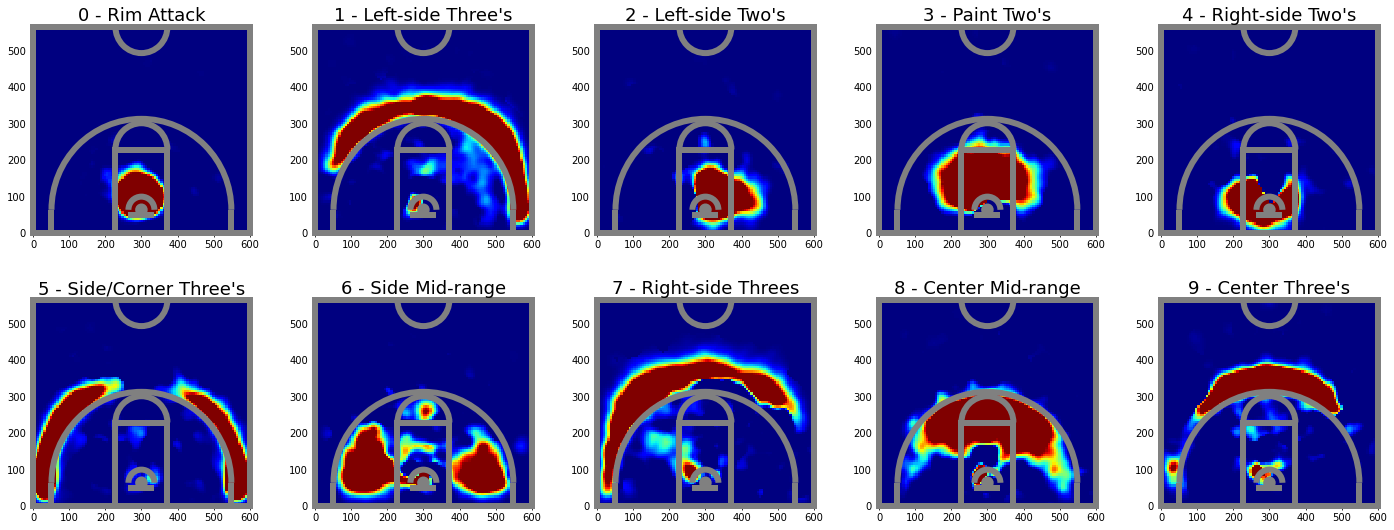

In [132]:
# Smooth-NMF (KL)
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
plt.subplot(2,5,1); plot_spatial_components(H_KL[0,:], xedges, yedges, title="0 - Rim Attack")
plt.subplot(2,5,2); plot_spatial_components(H_KL[1,:], xedges, yedges, title="1 - Left-side Three's")
plt.subplot(2,5,3); plot_spatial_components(H_KL[2,:], xedges, yedges, title="2 - Left-side Two's")
plt.subplot(2,5,4); plot_spatial_components(H_KL[3,:], xedges, yedges, title="3 - Paint Two's")
plt.subplot(2,5,5); plot_spatial_components(H_KL[4,:], xedges, yedges, title="4 - Right-side Two's")
plt.subplot(2,5,6); plot_spatial_components(H_KL[5,:], xedges, yedges, title="5 - Side/Corner Three's")
plt.subplot(2,5,7); plot_spatial_components(H_KL[6,:], xedges, yedges, title="6 - Side Mid-range")
plt.subplot(2,5,8); plot_spatial_components(H_KL[7,:], xedges, yedges, title="7 - Right-side Threes")
plt.subplot(2,5,9); plot_spatial_components(H_KL[8,:], xedges, yedges, title="8 - Center Mid-range")
plt.subplot(2,5,10); plot_spatial_components(H_KL[9,:], xedges, yedges, title="9 - Center Three's")
fig.tight_layout(pad=3.0)
plt.show()

In this plot, each of the basis vectors represents the normalized intensity function for a particular shot type. The intensity function acts as a sort of density over the different shot locations, and flashes red in places where shot attempts are most likely. Based on the exploratory analysis in Section 5, the first two components here are not at all surprising. Component 0 ("rim attacks") has a slight right-dominance, whereas Component 1 ("left-side three's") is surprisingly left-dominant. The next few components all represent different variations of paint and low-post two's. Again, it is surprising to see left-side two's (Component 2) come before right-side two's (Component 4). Perhaps this is because some similar right-side shots were already picked up by Component 0. We again see three-point shooting represented by Component 5 ("side/corner three's"), where there is a bit of right-hand dominance. Interestingly, Component 6 ("side mid-range") is really the first occurrence of true mid-range shooting (and slightly right-dominant). In the last few components, we see more three-point shot specialties (Component 7 and Component 9) and the appearance of long mid-range shots (Component 9). 

### 7.2 &emsp; Categorization of NCAA Players by Shot Behavior

Next, I examine the player-specific basis weights for a subset of NCAA players that were drafted in the first round of the 2018 NBA Draft. In doing so, I show that these weights can be used to gain insight about a player's shooting strengths and weaknesses. Additionally, I discuss how these weights can be used to cluster players on the basis of shooting behavior. Note that I display the normalized player-specific basis weights. Each number then represents the percent of shots taken by a particular player that fall under each component category.

In [115]:
# Create pandas dataframe of W
player_weights = pd.DataFrame(W_KL)

# Normalize the rows so they sum to one
player_weights.iloc[:,:] = Normalizer(norm='l1').fit_transform(player_weights).round(3)

# Combine with player name and information and turn into a Spark dataframe
player_weights_pd = pd.concat([player_idx, player_weights], axis=1)
player_weights_df = spark.createDataFrame(player_weights_pd)

# Define a list of top players from the 2018 draft
drafted_players = ["Deandre Ayton,DeAndre Ayton", "Marvin Bagley III", "Jaren Jackson Jr.", 
                   "Trae Young", "Mohamed Bamba", "Wendell Carter Jr.", "Collin Sexton", 
                   "Kevin Knox", "Mikal Bridges", "Shai Gilgeous-Alexander"]

# Subset dataframe to look at the weights for this selection of players
table = player_weights_df.where(player_weights_df.player_full_name.isin(drafted_players)).drop("player_id").toPandas()
components_list = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
table.style.applymap(lambda x: 'background-color : yellow' if x > 0.2 else '', subset = components_list)

,team_alias,player_full_name,num_shots,0,1,2,3,4,5,6,7,8,9
0,UK,Kevin Knox,441,0.095,0.27,0,0.146,0.101,0.08,0.214,0.017,0.077,0
1,UK,Shai Gilgeous-Alexander,377,0.16,0.045,0.265,0.183,0.061,0.062,0.072,0.019,0.107,0.027
2,VILL,Mikal Bridges,475,0.15,0.189,0.085,0.065,0.098,0.173,0.035,0.111,0.05,0.044
3,ARIZ,"Deandre Ayton,DeAndre Ayton",451,0.35,0,0.133,0.049,0.035,0,0.153,0.004,0.197,0.078
4,DUKE,Marvin Bagley III,440,0.215,0.031,0.433,0.072,0.137,0.009,0,0,0.006,0.097
5,DUKE,Wendell Carter Jr.,318,0.167,0.008,0.396,0.027,0.177,0.004,0.028,0,0.059,0.135
6,OKLA,Trae Young,603,0.195,0.045,0.018,0.142,0.003,0.018,0.01,0.465,0.017,0.087
7,TEX,Mohamed Bamba,253,0.39,0.033,0.07,0.056,0.186,0.004,0.093,0,0.014,0.153
8,ALA,Collin Sexton,437,0.204,0.085,0.127,0.069,0.064,0,0.025,0.161,0.177,0.088
9,MSU,Jaren Jackson Jr.,232,0.134,0.174,0.316,0.066,0.039,0.028,0,0,0.017,0.225


The above table displays the normalized player-specific basis weights for the top NCAA prospects in the 2018 NBA Draft. Note that Deandre Ayton's name was not consistently spelled, which is why it appears twice. Looking at the values, you can see that most players shoot a high frequency of Component 0 ("rim attack") and Component 2 ("left-side two's") shots. It is unsurprising that these low distance shots have such high weights, because the majority of the top prospects in 2018 were Power Forwards or Centers. What is surprising, though, is the higher frequency of left-handed two's compared to right-handed two's. As it turns out, several of these players (Jaren Jackson, Marvin Bagley III, Shai Gilgeous-Alexander) are either left-handed or prefer a left-hand finish. In contrast, players like Kentucky's Kevin Knox and Oklahoma's Trae Young shoot three-point shots with the highest frequency. While Knox takes the majority of his three's from the left (Component 1), Young shoots from the right (Component 7). It is worth noting, also, that Mikal Bridges does not have a weight above 20% for any particular shot type. This speaks to his ability to shoot from all over the floor.

While this table says a lot about where players prefer to shoot, it also says a lot about where they don't. As such, analyzing player-specific basis weights is a useful tool for any college or professional basketball organization to use for scouting top prospects. For example, one of the biggest critiques of Duke's Marvin Bagley III going into the draft was his seeming inability to play or shoot from the right side of the court. This is heavily reflected in his basis weights, as his left-side two's (Component 2) are three times more frequent than his right-side two's (Component 4). Similarly, draft reports indicated that one of Kevin Knox's biggest weaknesses was his inability to drive to the left. This is noticeable is his basis weights as the frequency of left-side two's (Component 2) is actually zero.

In addition to assessing players individually, these basis weights can be used to categorize players on the basis of their shooting behaviors. Looking at the table above, one grouping would consist of players Deandre Ayton, Mohamed Bamba and Collin Sexton because of their high Component 0 ("rim attack") weights. Another group would consist of Kevin Knox and Mikal Bridges because of their high frequency of Component 1 ("left-side three's") weights. While there are obviously more factors than just shooting to consider when scouting prospects, there is still some value in grouping players on the basis of shot behavior. This would especially be useful for a team looking to fill a specific role, and want to get a sense of whether or not a player's shot behavior would fit with their expectations and their offensive system.

### 7.3 &emsp; Comparing Team Rosters and Shooting Strategies

Next, I discuss how analyzing the player-specific basis weights for two team rosters can say a lot about differing offensive strategies. Below, I display the player-specific basis weights for the 2017-18 UVA and Villanova rosters. UVA and Villanova were two of the top teams during the 2017-18 season and were both number one seeds going into the 2018 March Madness Tournament. While the Villanova Wildcats went on to win the tournament, UVA made history in its own way by becoming the first number one seed to lose in the first round. Let's see if comparing the player-specific basis weights for both teams' rosters says anything about their different offensive strategies.

In [134]:
table = player_weights_df.where("team_alias = 'UVA'").drop("player_id").toPandas()
table.style.applymap(lambda x: 'background-color : yellow' if x > 0.2 else '', subset = components_list)

,team_alias,player_full_name,num_shots,0,1,2,3,4,5,6,7,8,9
0,UVA,Kyle Guy,429,0.056,0.091,0.086,0.08,0.03,0.255,0.159,0.149,0.081,0.013
1,UVA,Ty Jerome,316,0.005,0.13,0.106,0.22,0.038,0.102,0.037,0.278,0.08,0.004
2,UVA,Mamadi Diakite,130,0.312,0,0,0.179,0.224,0,0.23,0,0.055,0
3,UVA,Isaiah Wilkins,172,0.158,0.011,0.238,0.19,0.006,0.039,0.066,0,0.233,0.06
4,UVA,De'Andre Hunter,212,0.16,0.022,0.064,0.051,0.156,0.183,0.119,0.026,0.188,0.03
5,UVA,Devon Hall,291,0.106,0.142,0.08,0.175,0.048,0.268,0.057,0.06,0.065,0
6,UVA,Jack Salt,80,0.437,0,0.084,0.131,0.341,0,0.008,0,0,0
7,UVA,Nigel Johnson,145,0.111,0,0.172,0.017,0.058,0.192,0.075,0.14,0.201,0.034


In [137]:
table = player_weights_df.where("team_alias = 'VILL'").drop("player_id").toPandas()
table.style.applymap(lambda x: 'background-color : yellow' if x > 0.2 else '', subset = components_list)

,team_alias,player_full_name,num_shots,0,1,2,3,4,5,6,7,8,9
0,VILL,Jalen Brunson,516,0.073,0.13,0.138,0.146,0.058,0.043,0.036,0.157,0.114,0.105
1,VILL,Dhamir Cosby-Roundtree,68,0.616,0,0,0,0.365,0,0.019,0,0,0
2,VILL,Eric Paschall,271,0.232,0.168,0.183,0.107,0.036,0.16,0,0.06,0.054,0
3,VILL,Mikal Bridges,475,0.15,0.189,0.085,0.065,0.098,0.173,0.035,0.111,0.05,0.044
4,VILL,Omari Spellman,336,0.093,0.042,0.043,0.083,0.182,0.241,0.115,0.023,0.039,0.14
5,VILL,Collin Gillespie,93,0.046,0.388,0,0,0.196,0.187,0,0.175,0.009,0
6,VILL,Donte DiVincenzo,389,0.094,0.237,0.09,0.033,0.113,0.06,0.01,0.177,0.092,0.092
7,VILL,Phil Booth,245,0.104,0.232,0.056,0.058,0.103,0.089,0.027,0.221,0.035,0.075


Looking at the player-specific basis weights for UVA's roster, one thing is clear - the roster is very well-balanced in that many different shot preferences are represented. No more than two players have the highest weight in the same shot type category. This indicates that UVA runs an offensive system where each player knows their role and stays in their respective zone. Additionally, UVA's offensive strategy involves many different shot types. Of the eight players with more than 50 shot attempts, three would be categorized as either Component 0 ("rim attack") or Component 2 ("left-side two's") shooters. Two players would be categorized as Component 8 ("center mid-range") shooters. The remaining three would be categorized as either Component 5 ("side/corner three's") or Component 7 ("right-side three's") shooters.

In comparison to UVA's roster, Villanova's is not nearly as balanced. Of the eight players with more than 50 shot attempts, four would be categorized as Component 1 ("left-side three's") shooters. Two would be categorized as Component 0 ("rim attack") shooters. The remaining two players would be categorized as either Component 5 ("side/corner three's") or Component 7 ("right-side three's") shooters. Clearly, Villanova's offensive strategy is much more aggressive than that of UVA. This is consistent with UVA's reputation as a low-scoring, defense-first team. Additionally, Villanova seems to have abandoned the long mid-range shot entirely. Only Jalen Brunsen, Omari Spellman and Donte DiVincenzo have somewhat high weights in either of the mid-range shot categories (Components 6 and 8). Perhaps Villanova's emphasis on three-point shooting can explain in part why their 2018 tournament run was such a success. UVA's conservative strategy in the 2017-18 season, in contrast, may not have been well-suited for tournament-style play.  

### 7.4 &emsp; Changes in Shooting Preferences Over the Years

Lastly, I will apply KL-based Smooth NMF to three shot matrices representing all of the shots taken during the 2013-14, 2015-16, and 2017-18 seasons respectively. To do so, I repeat the process detailed in Section 6. After grouping each dataset by player ID and removing any players with fewer than 50 shots, I am left with 155,231 shots distributed among 847 unique players for the 2013-14 season; 253,046 shots distributed among 1,501 players for the 2015-16 season; and 215,962 shots distributed among 1,320 unique players for the 2017-18 season. Then, the number of rows in each shot matrix corresponds with the number of unique players and the number of columns is equal to the total number of bins. Recall that because I am splitting the court into 6" by 6" tiles, there are 9,400 total bins. After applying KL-based Smooth NMF to all three of my shot matrices separately, I plot the resulting basis vectors for comparison.

In [140]:
# Write SQL query
query_string = """
    SELECT team_alias,
    team_basket,
    player_id,
    player_full_name,
    event_coord_x,
    event_coord_y,
    shot_made
    FROM df
    WHERE type = "fieldgoal"
        AND event_coord_x IS NOT NULL
        AND event_coord_y IS NOT NULL
"""

# Run query and save to Spark dataframe
df_shots = spark.sql(query_string)

# Adjust the (x,y)-coordinates
df_shots_adj = adjust_coordinates(df_shots)                                  

# Subset by season
df_shots_adj_13 = df_shots_adj.filter("season = 2013")
df_shots_adj_15 = df_shots_adj.filter("season = 2015")
df_shots_adj_17 = df_shots_adj.filter("season = 2017")

# Aggregte each player's shot attempts and remove any player with fewer than 50 shot attempts
df_shots_agg_13 = aggregate_shots(df_shots_adj_13)
df_shots_agg_15 = aggregate_shots(df_shots_adj_15)
df_shots_agg_17 = aggregate_shots(df_shots_adj_17)

# Print the total number of players and total number of shots
print("Number of Players (2013): ", df_shots_agg_13.count())
print("Number of Shots (2013): ", df_shots_agg_13.agg({"num_shots":"sum"}).collect()[0][0])
print(" ")
print("Number of Players (2015): ", df_shots_agg_15.count())
print("Number of Shots (2015): ", df_shots_agg_15.agg({"num_shots":"sum"}).collect()[0][0])
print(" ")
print("Number of Players (2017): ", df_shots_agg_17.count())
print("Number of Shots (2017): ", df_shots_agg_17.agg({"num_shots":"sum"}).collect()[0][0])

Number of Players (2013):  847
Number of Shots (2013):  155231
 
Number of Players (2015):  1501
Number of Shots (2015):  253046
 
Number of Players (2017):  1320
Number of Shots (2017):  215962


In [141]:
# Create the smoothed two-dimensional histograms for each player's shots:
df_shots_binned_13 = df_shots_agg_13.withColumn("binned_smooth", udf_bin_shots_smooth("x", "y"))
df_shots_binned_15 = df_shots_agg_15.withColumn("binned_smooth", udf_bin_shots_smooth("x", "y"))
df_shots_binned_17 = df_shots_agg_17.withColumn("binned_smooth", udf_bin_shots_smooth("x", "y"))

# Convert to a Pandas dataframe
tmp_13 = df_shots_binned_13.select("player_id", "team_alias", "player_full_name", "binned_smooth").toPandas()
tmp_15 = df_shots_binned_15.select("player_id", "team_alias", "player_full_name", "binned_smooth").toPandas()
tmp_17 = df_shots_binned_17.select("player_id", "team_alias", "player_full_name", "binned_smooth").toPandas()

# Convert each row to a numpy array
tmp_13['binned_smooth'] = tmp_13['binned_smooth'].apply(lambda x: np.array(x))
tmp_15['binned_smooth'] = tmp_15['binned_smooth'].apply(lambda x: np.array(x))
tmp_17['binned_smooth'] = tmp_17['binned_smooth'].apply(lambda x: np.array(x))

# Create a player index
player_idx_13 = tmp_13[["player_id", "team_alias", "player_full_name"]]
player_idx_15 = tmp_15[["player_id", "team_alias", "player_full_name"]]
player_idx_17 = tmp_17[["player_id", "team_alias", "player_full_name"]]

# Create the shot matrix (smoothed/normalized bins and raw counts)
shot_matrix_smooth_13 = np.array(tmp_13.binned_smooth.tolist())
shot_matrix_smooth_15 = np.array(tmp_15.binned_smooth.tolist())
shot_matrix_smooth_17 = np.array(tmp_17.binned_smooth.tolist())

print("Dimensions of 2013 Shot Matrix: ", np.shape(shot_matrix_smooth_13))
print("Dimensions of 2015 Shot Matrix: ", np.shape(shot_matrix_smooth_15))
print("Dimensions of 2017 Shot Matrix: ", np.shape(shot_matrix_smooth_17))

Dimensions of 2013 Shot Matrix:  (847, 9400)
Dimensions of 2015 Shot Matrix:  (1501, 9400)
Dimensions of 2017 Shot Matrix:  (1320, 9400)


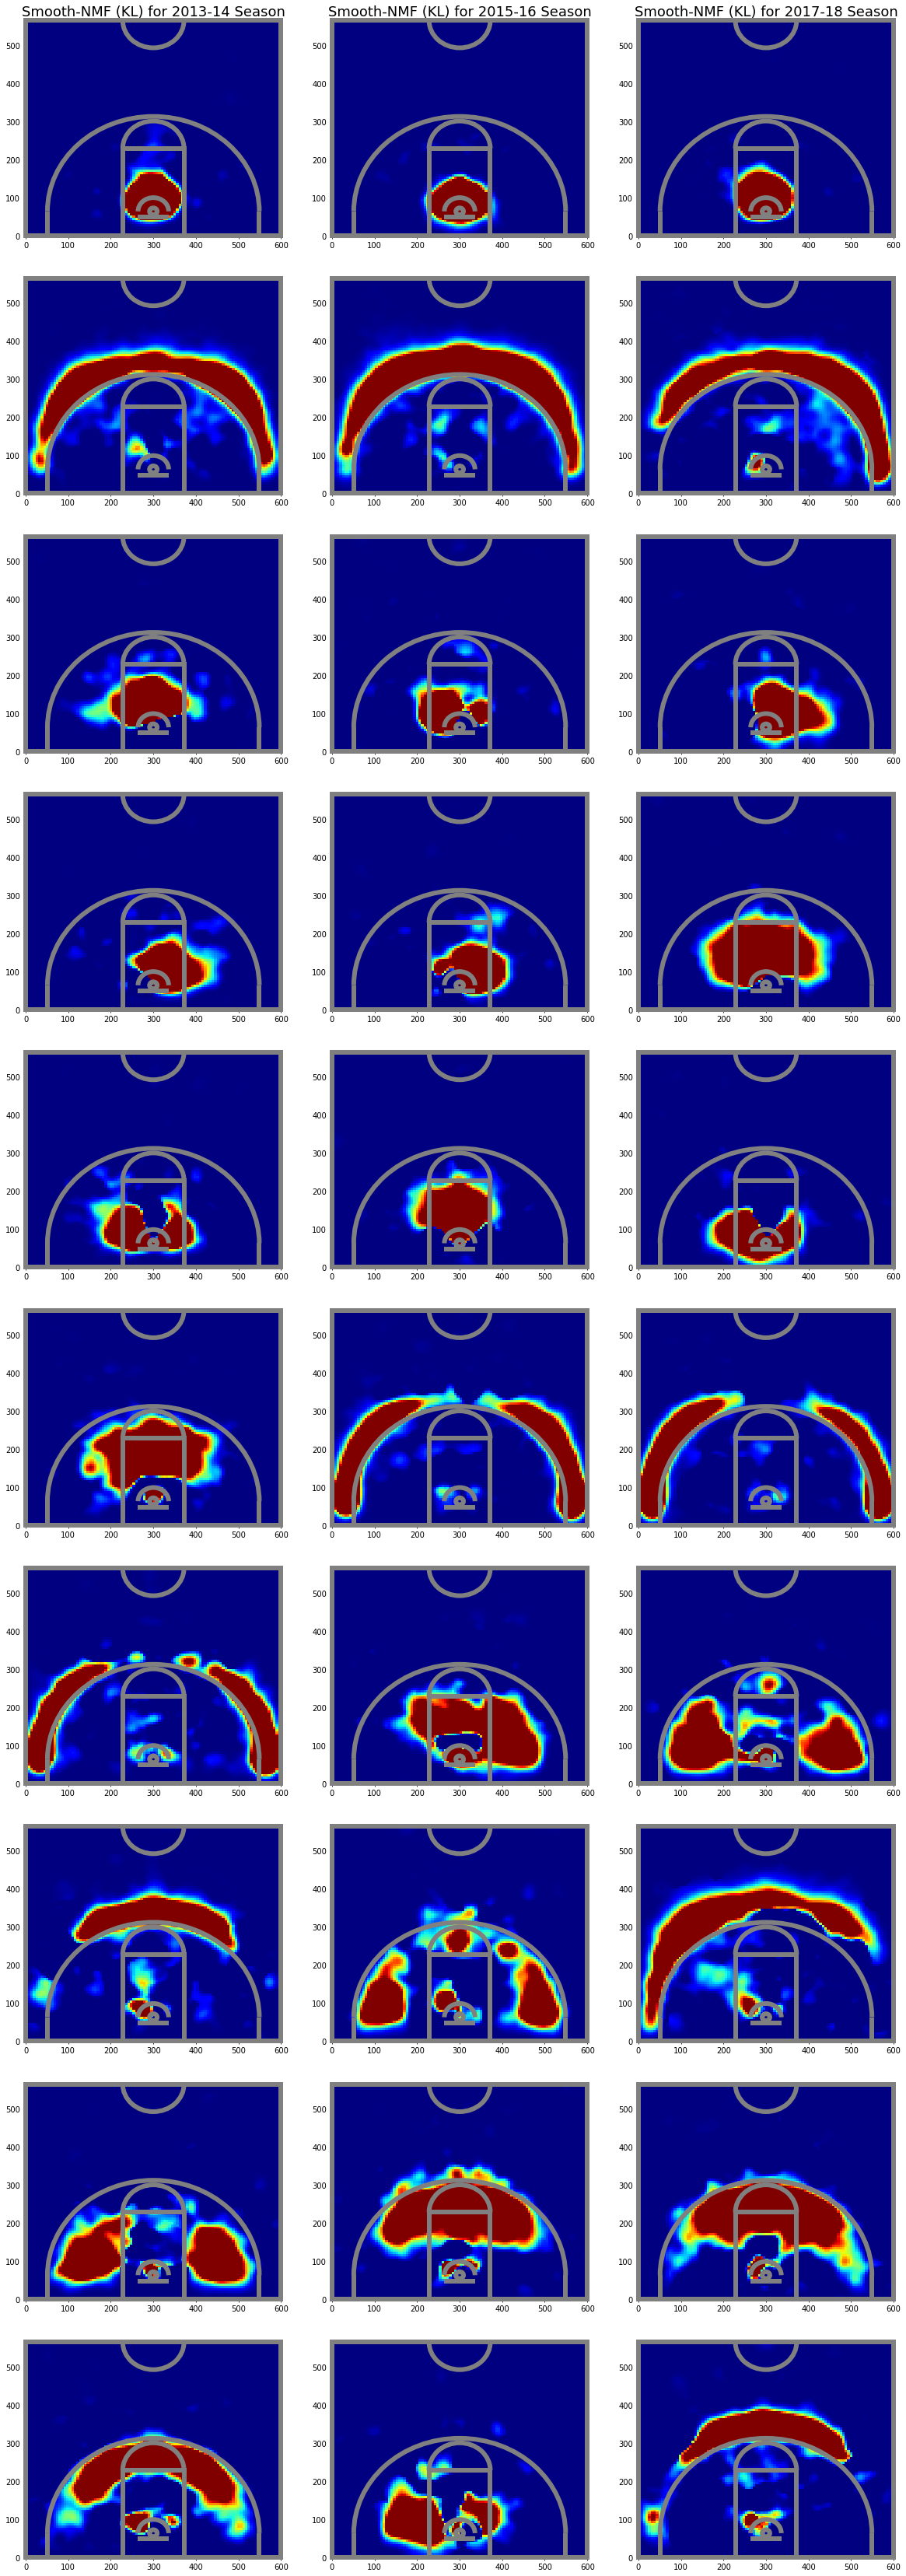

In [143]:
# LGCP-NMF (KL)
W_13, H_13 = apply_nmf(shot_matrix_smooth_13, n_components=10, beta_loss='kullback-leibler')
W_15, H_15 = apply_nmf(shot_matrix_smooth_15, n_components=10, beta_loss='kullback-leibler')
W_17, H_17 = apply_nmf(shot_matrix_smooth_17, n_components=10, beta_loss='kullback-leibler')

# Visualize the results
fig, ax = plt.subplots(10, 3, figsize=(20,60))

# Smooth-NMF (KL) for 2013 shots
plt.subplot(10,3,1); plot_spatial_components(H_13[0,:], xedges, yedges, title="Smooth-NMF (KL) for 2013-14 Season")
plt.subplot(10,3,4); plot_spatial_components(H_13[1,:], xedges, yedges)
plt.subplot(10,3,7); plot_spatial_components(H_13[2,:], xedges, yedges)
plt.subplot(10,3,10); plot_spatial_components(H_13[3,:], xedges, yedges)
plt.subplot(10,3,13); plot_spatial_components(H_13[4,:], xedges, yedges)
plt.subplot(10,3,16); plot_spatial_components(H_13[5,:], xedges, yedges)
plt.subplot(10,3,19); plot_spatial_components(H_13[6,:], xedges, yedges)
plt.subplot(10,3,22); plot_spatial_components(H_13[7,:], xedges, yedges)
plt.subplot(10,3,25); plot_spatial_components(H_13[8,:], xedges, yedges)
plt.subplot(10,3,28); plot_spatial_components(H_13[9,:], xedges, yedges)

# Smooth-NMF (KL) for 2015 shots
plt.subplot(10,3,2); plot_spatial_components(H_15[0,:], xedges, yedges, title="Smooth-NMF (KL) for 2015-16 Season")
plt.subplot(10,3,5); plot_spatial_components(H_15[1,:], xedges, yedges)
plt.subplot(10,3,8); plot_spatial_components(H_15[2,:], xedges, yedges)
plt.subplot(10,3,11); plot_spatial_components(H_15[3,:], xedges, yedges)
plt.subplot(10,3,14); plot_spatial_components(H_15[4,:], xedges, yedges)
plt.subplot(10,3,17); plot_spatial_components(H_15[5,:], xedges, yedges)
plt.subplot(10,3,20); plot_spatial_components(H_15[6,:], xedges, yedges)
plt.subplot(10,3,23); plot_spatial_components(H_15[7,:], xedges, yedges)
plt.subplot(10,3,26); plot_spatial_components(H_15[8,:], xedges, yedges)
plt.subplot(10,3,29); plot_spatial_components(H_15[9,:], xedges, yedges)

# Smooth-NMF (KL) for 2017 shots
plt.subplot(10,3,3); plot_spatial_components(H_17[0,:], xedges, yedges, title="Smooth-NMF (KL) for 2017-18 Season")
plt.subplot(10,3,6); plot_spatial_components(H_17[1,:], xedges, yedges)
plt.subplot(10,3,9); plot_spatial_components(H_17[2,:], xedges, yedges)
plt.subplot(10,3,12); plot_spatial_components(H_17[3,:], xedges, yedges)
plt.subplot(10,3,15); plot_spatial_components(H_17[4,:], xedges, yedges)
plt.subplot(10,3,18); plot_spatial_components(H_17[5,:], xedges, yedges)
plt.subplot(10,3,21); plot_spatial_components(H_17[6,:], xedges, yedges)
plt.subplot(10,3,24); plot_spatial_components(H_17[7,:], xedges, yedges)
plt.subplot(10,3,27); plot_spatial_components(H_17[8,:], xedges, yedges)
plt.subplot(10,3,30); plot_spatial_components(H_17[9,:], xedges, yedges)
plt.show()

Looking at the basis vectors for each season, there are quite a few similarities. The first two components across the board are rim attacks and three-pointers (though in 2017-18 it is more of a left-side three than an all-around the arc three). The next few components are all representative of short-distance two's (with some variation in the order of left-side, right-side or paint). For some reason, the 2017-18 season exhibits a bit more left-hand dominance than the other two seasons do. Regardless, the similarities in the first five basis vectors shows some consistency in shooting behavior over the years.

After this point, however, the basis vectors begin to differ. In the 2013-14 season, Components 5, 8, and 9 represent shorter center, side, and longer center mid-range shots, respectively. The remaining two components (6 and 7) are side/corner and center three's, respectively. In the 2015-16 season, the center/corner three appears earlier (in Component 5). This is followed by a series of mid-range shots (left, side and center for Components 6, 7 and 8, respectively). Lastly, Component 9 is another right-side two. In the 2017-18 season, you also see center/corner three's at Component 5. Of the remaining components, two are mid-range shots (side mid-range shot in Component 6 and center mid-range in Component 8). Additionally, there are two three-point shots (right-side three in Component 7 and center three in Component 9).

The similarities across basis vectors up until Component 5 points to a consistent preference for rim attack shots, three's and short-distance two's. Over the years, however, there is an increasing preference for three-point shots. In 2017-18, four of the ten basis vectors depict three-point shots (compared with three in 2013-14 and two in 2015-16). Additionally, this increasing preference for three-point shots is not coming at the expense of rim attacks or short-range two's, but rather of longer mid-range shots. Interestingly, the side mid-range shot is the only mid-range shot that actually increased in frequency each season. While there are some interesting takeaways here, I think there would be more differences if the comparisons were made over a longer period of time (perhaps comparing different decades or half-decades).  

## 8 &emsp; Conclusion

In this report, I have shown how the BigQuery Storage API and the Spark-BigQuery connector can be used to load and analyze the large quantities of NCAA Men's Basketball shot data that is available. Through the use of SQL queries, I have conducted an exploratory analysis of the dataset that shed light on some of the major shooting trends over a five-season period. Using non-negative matrix factorization, I have shown that it is possible to delve deeper into understanding the underlying structure of NCAA player shooting distributions. By analyzing and plotting the resulting spatial basis vectors, I have been able to visualize and interpret the different shot type preferences in the NCAA. Looking at the normalized player-specific basis weights, I have shown that NMF can be used as a clustering technique, categorizing players on the basis of shooting behavior. I have also shown how these values can be used by NBA scouts to learn more about a player's offensive strengths and weaknesses. Lastly, I applied NMF to the shot matrices for three individual seasons and compared the results to infer how shot preferences in the NCAA have changed over time.

There are a few potential directions for future work. This analysis focused on factorizing a shot count matrix based on shot attempt frequency, but does little to address shot efficiency. Applying NMF to a matrix of shot efficiency in different areas of the court would allow us to visualize what kinds of shots are typically most successful. The resulting player-specific basis weights would be extraordinarily useful for NBA scouts to get a more accurate sense of a player's strengths. Additionally, this could be helpful for opposing teams to prepare for upcoming matchups. Equipped with this information, teams could prepare defensive strategies that involve forcing shooters into areas of the court where they aren't typically as successful. Another potential area for exploration involves incorporating important information about how shots are being defended. As an example, one might consider again separating the court into tiles and calculating the average defender distance for shots taken within each tile. The results could be extremely helpful for teams preparting for upcoming games. Examining the resulting team-specific basis weights would give teams an idea of where their opponent's defense breaks down. The teams could then target those areas of the court as ideal shot locations.

## References

[1] &nbsp; Piette, James; Anand, Sathyanarayan; and Zhang, Kai (2010) "Scoring and Shooting Abilities of NBA Players," *Journal of Quantitative Analysis in Sports,* 6(1): Article 1.

[2] &nbsp; Bruce, Scott (2016) "A scalable framework for NBA player and team comparisons using player tracking data," *Journal of Sports Analytics,* 2: 107-119.

[3] &nbsp; Miller, Andrew; Bornn, Luke; Adams, Ryan; and Goldsberry, Kirk (2014) "Factorized Point Process Intensities: A Spatial Analysis of Professional Basketball," *31st International Conference on Machine Learning, ICML 2014,* 398-414.

[4] &nbsp; Franks, Alexander; Miller, Andrew; Bornn, Luke; and Goldsberry, Kirk (2015) "Characterizing the spatial structure of defensive skill in professional basketball," *Annals of Applied Statistics,* 9(1): 94-121.

[5] &nbsp; Lee, Daniel D. and Seung, H. Sebastian (2001) "Algorithms for Non-negative Matrix Factorization," *Advances in Neural Information Processing Systems (NIPS),* 13: 556–562.

[6] &nbsp; Google Cloud Platform, NCAA Basketball Dataset, available at https://console.cloud.google.com/marketplace/details/ncaa-bb-public/ncaa-basketball.

[7] &nbsp; Google Cloud Platform, "BigQuery Storage API overview," available at https://cloud.google.com/bigquery/docs/reference/storage.

[8] &nbsp; Apache Spark SQL connector for Google BigQuery (Beta), available at https://github.com/GoogleCloudDataproc/spark-bigquery-connector.

[9] &nbsp; Sportradar, NCAA Men's Basketball API, available at https://developer.sportradar.com/docs/read/basketball/NCAA_Mens_Basketball_v7.

[10] &nbsp; Tjortjoglou, Savvas, "nbashots," available at https://github.com/savvastj/nbashots.